# JoDa kurssin Tampereen BNB projekti. Regressiomallin toteuttaminen hinnalle käyttäen NAS.
Koska en tiedä, pitääkö projekti olla yhdessä Jupyter skriptissä vai ei. Niin teen tähän aika pitkän skriptin joka tekee kaiken. Lisäksi laitan mukaan erilliset Jupyter skriptit joissa hieman paremmin ositeltu eri asiat. 
Projekti löytyy myös 
[JoDa kurssin repo](https://github.com/THalfar/JoDa) 

Tämä on hieman hätiköidysti yhteen tehty, koska sähläämiseni takia oletin dediksen olevan vasta ensi viikolla. Aikaa tähän kyllä käytin huhtikuun alussa paljon, kunnes Kaggle kisa vei mennessään. 

Alla on erikseen tähän projektiin liittyvät skriptit: 

- "tampereBNB_datan_kasittely.ipynb"  Datan esikäsittely
 
- "tampere_reg.ipynb" Itse regressiomalli jossa käytetään NAS ja pyritään eri ositteluiden tuottamien neuroverkkojen toiseksi viimeisen kerroksen ulostuloa käyttää ominaisuuksina XGBoost 

- "baseline.ipynb" Tämä on pohjamalli, joka käyttää XGBoost jotta voin verrata tuloksia siihen. Vaikutti siltä, että käytössä oleva aineisto on liian pieni syväoppimiseen, koska tämä tuotti parhaita tuloksia.



In [93]:
# Tarvittavat kirjastot 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler 
import optuna
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
import time 
from optuna.integration import TFKerasPruningCallback
import pickle 
from datetime import timedelta
import gc
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold


In [94]:
# !!! Jos liian ei liian isot tulosteet rasita, kannattaa ottaa nämä mukaan. Itse pidän koko tulosteen katsomisesta, mutta se ei ehkä sovi kaikille.
# pd.set_option('display.max_row', None) 
# pd.set_option('display.max_columns', None) 

## Datan esikäsittely. 

Tässä osiossa käsittelen dataa koneoppimisen mallia varten. 

Käytännössä tämä on "tampereBNB_datan_kasittely.ipynb" johon lisätty kommentteja mitä tapahtuu. Osiossa tarkastellaan käytössä olevaa dataa ja siivotaan sitä jatkokäyttöä varten. 

In [95]:
# Luetaan data 
df_train = pd.read_csv('./data/Tampere_BNB_training_listing.csv')
df_test = pd.read_csv('./data/Tampere_BNB_testing_listing.csv')

In [96]:
df_train.describe()

,m2,Rv,Pituusaste,Leveysaste,Hinta
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,60.947870,1990.896296,23.796642,61.485415,283.833333
std,28.571568,26.501165,0.102356,0.026275,140.907735
min,12.000000,1880.000000,23.581308,61.430235,36.000000
25%,40.500000,1970.000000,23.730274,61.466342,192.000000
50%,56.500000,1990.000000,23.793908,61.493092,255.000000
75%,75.000000,2018.000000,23.854114,61.501942,339.000000
max,259.000000,2024.000000,24.070784,61.627915,1299.000000


In [97]:
df_train.head()
df_train['Talot.'].value_counts()

Talot.
kt    883
rt    162
ok     35
Name: count, dtype: int64

In [98]:
puuttuvat_arvot = df_train.isnull().sum()
puuttuvat_arvot = puuttuvat_arvot[puuttuvat_arvot > 0]
print(f"Puuttuvat arvot:\n {puuttuvat_arvot}")

Puuttuvat arvot:
 Krs       62
Kunto    294
dtype: int64


In [99]:
puuttuvat_arvot_prosentteina = (puuttuvat_arvot / len(df_train)) * 100
print(f"Puuttuvat arvot prosentteina:\n {puuttuvat_arvot_prosentteina}")

Puuttuvat arvot prosentteina:
 Krs       5.740741
Kunto    27.222222
dtype: float64


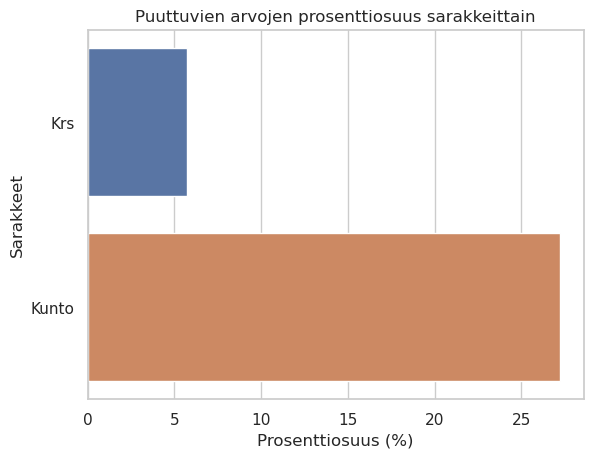

In [100]:
puuttuvat_arvot_prosentteina = puuttuvat_arvot_prosentteina.sort_values() 

sns.set_theme(style="whitegrid")
sns.barplot(x=puuttuvat_arvot_prosentteina, y=puuttuvat_arvot_prosentteina.index)
plt.title('Puuttuvien arvojen prosenttiosuus sarakkeittain')
plt.xlabel('Prosenttiosuus (%)')
plt.ylabel('Sarakkeet')
plt.show()

In [101]:
# Muutetaan Rv sarakkeen tyyppi kokonaisluvuksi
df_train['Rv'] = df_train['Rv'].astype(int)

In [102]:
df_train['Rv'].head()

0    2020
1    2018
2    2020
3    1964
4    1995
Name: Rv, dtype: int64

Korvataan "Kunto" sarakkeen tyhjät arvot "Ei tietoa"

<Axes: xlabel='Kunto'>

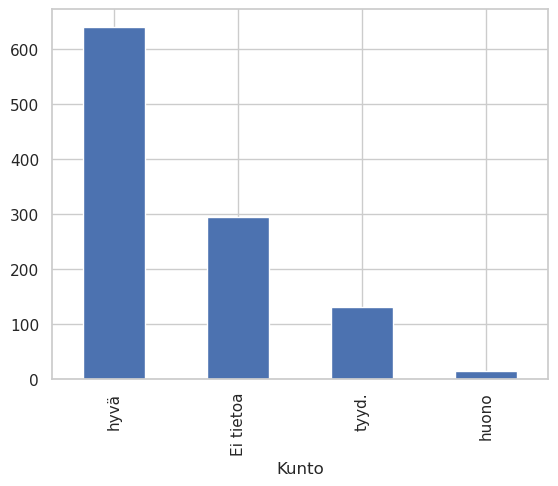

In [103]:
df_train['Kunto'] = df_train['Kunto'].fillna('Ei tietoa')
df_train['Kunto'].value_counts().plot(kind='bar')

In [104]:
kunto_mappaus = {
    'Ei tietoa': 0,
    'huono': 1,
    'tyyd.': 2,
    'hyvä': 3,
}
df_train['Kunto'] = df_train['Kunto'].map(kunto_mappaus)
df_train.head()

,Kaupunginosa,Huoneisto,Talot.,m2,Rv,Krs,Hissi,Kunto,Asunnon tyyppi,Pituusaste,Leveysaste,Hinta
0,Niemenranta,"2h , kt, s, p",kt,50.0,2020,2/6,on,3,Kaksi huonetta,23.696606,61.524269,300
1,Vuores,1 H + KT,kt,28.0,2018,1/4,on,3,Yksiö,23.804092,61.433185,162
2,Niemenranta,"3 h , kt , s, p",kt,63.0,2020,3/6,on,3,Kolme huonetta,23.696636,61.519368,363
3,Keskusta,3h+k+vh+kph/wc+...,kt,84.0,1964,5/7,on,0,Kolme huonetta,24.062369,61.463896,483
4,Hervanta,"2 h, kk, s, ph, p",kt,52.0,1995,6/6,on,2,Kaksi huonetta,23.848751,61.446601,174


In [105]:
df_train['Kunto'].value_counts()   

Kunto
3    641
0    294
2    130
1     15
Name: count, dtype: int64

In [106]:
df_train['Hissi'].value_counts()

Hissi
on    683
ei    397
Name: count, dtype: int64

In [107]:
df_train['Hissi'] = df_train['Hissi'].astype('category')
df_train['Hissi'] = df_train['Hissi'].cat.codes
df_train['Hissi'].value_counts()

Hissi
1    683
0    397
Name: count, dtype: int64

In [108]:
df_train['Kaupunginosa'].value_counts()

Kaupunginosa
Hervanta         73
Kaleva           62
Tammela          59
Hervantajärvi    54
Keskusta         50
                 ..
Lintuhytti        1
Kalkunvuori       1
Ristinarkku       1
Sorsapuisto       1
Kohmankaari       1
Name: count, Length: 94, dtype: int64

<Axes: xlabel='Kaupunginosa'>

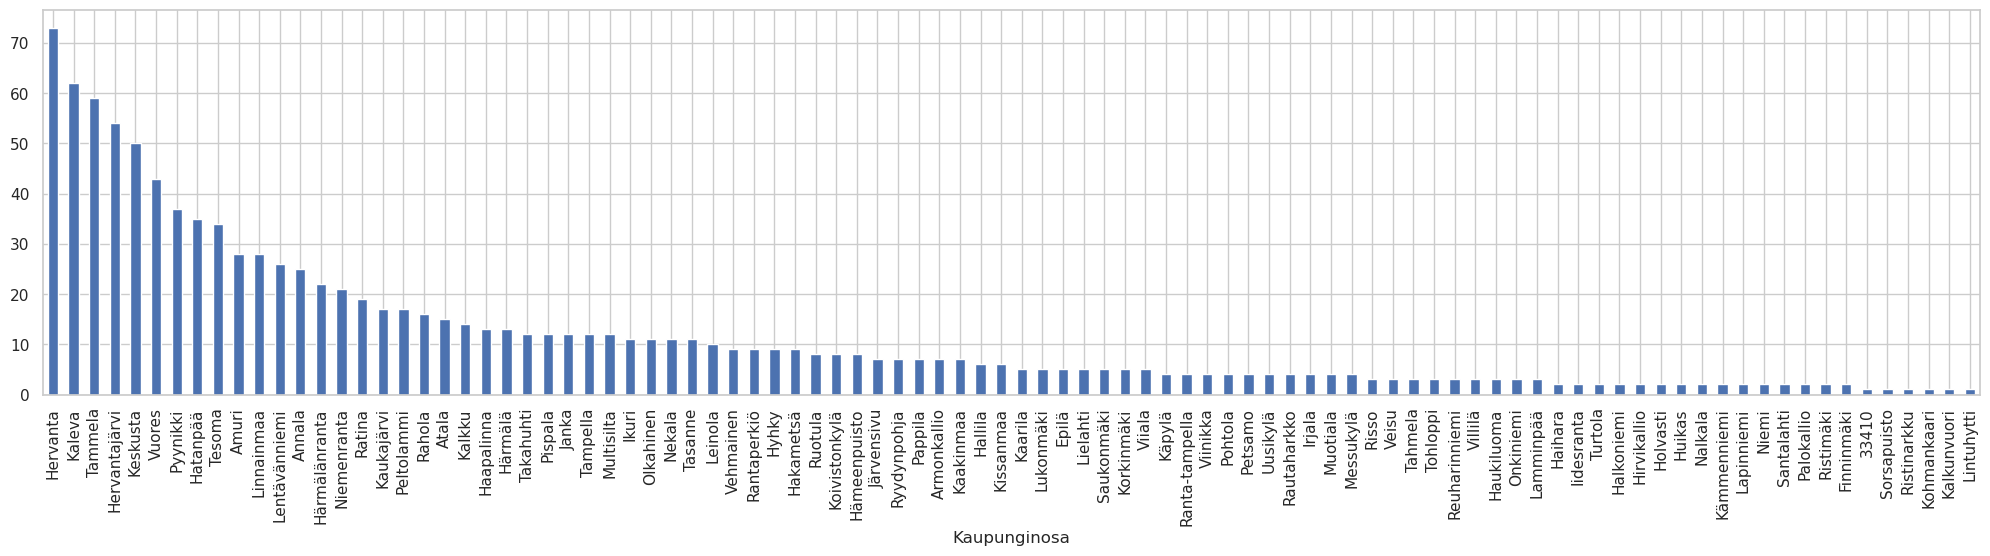

In [109]:
df_train['Kaupunginosa'] = df_train['Kaupunginosa'].astype('category')   
df_train['Kaupunginosa'].value_counts().plot(kind='bar', figsize=(25,5)) 

Koska kaupunginosia on niin paljon, tein ratkaisun missä liian pienet paikat yhdistetään yhdeksi. Tämä todennäköisesti jälkikäteen mietittynä vähän huono ratkaisu, mutta mennään tällä. 

<Axes: xlabel='Kaupunginosa'>

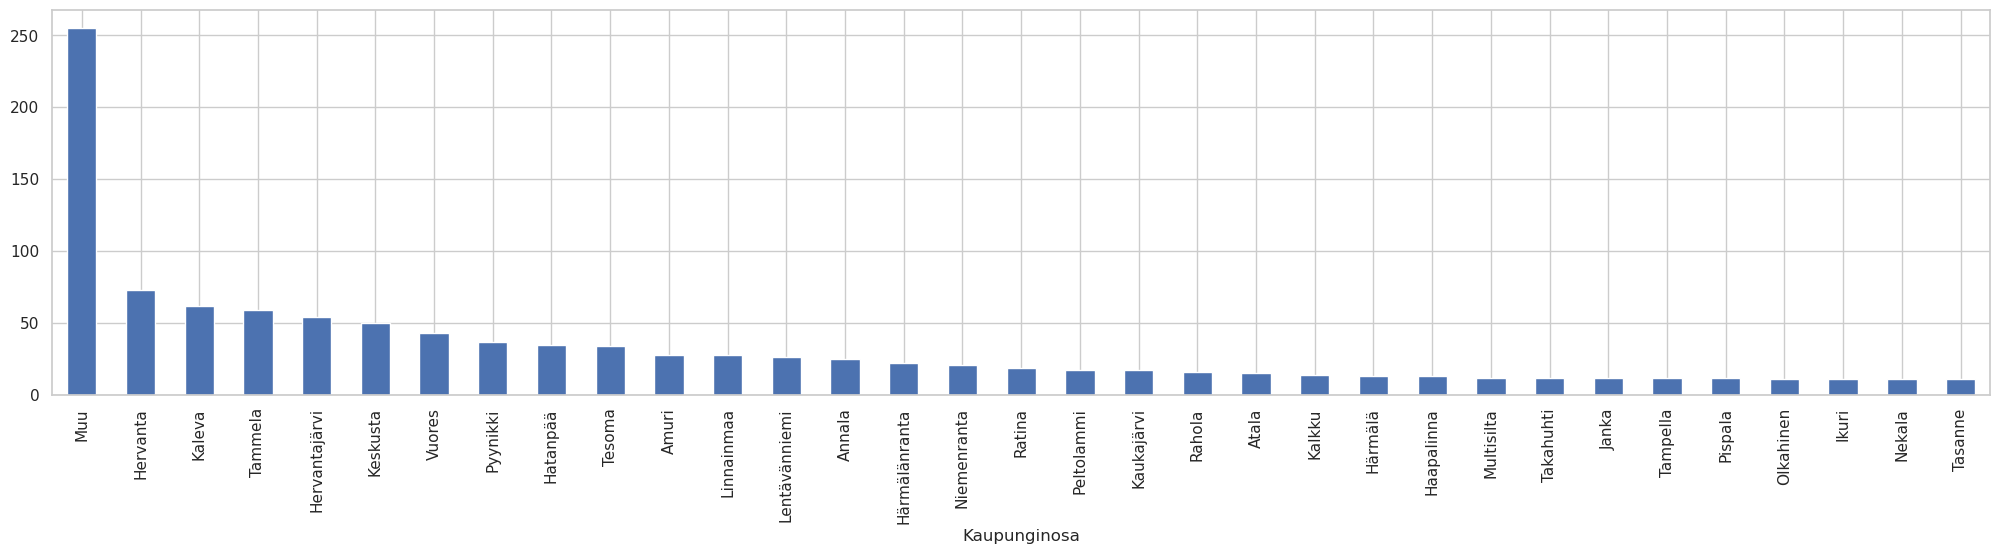

In [110]:
raja_arvo = 0.01
maarat = df_train['Kaupunginosa'].value_counts(normalize=True)
pienet_ryhmat = maarat[maarat < raja_arvo].index
df_train['Kaupunginosa'] = df_train['Kaupunginosa'].replace(pienet_ryhmat, 'Muu')
df_train['Kaupunginosa'].value_counts().plot(kind='bar', figsize= (25,5))

In [111]:
df_train['Kaupunginosa'].value_counts()

Kaupunginosa
Muu              255
Hervanta          73
Kaleva            62
Tammela           59
Hervantajärvi     54
Keskusta          50
Vuores            43
Pyynikki          37
Hatanpää          35
Tesoma            34
Amuri             28
Linnainmaa        28
Lentävänniemi     26
Annala            25
Härmälänranta     22
Niemenranta       21
Ratina            19
Peltolammi        17
Kaukajärvi        17
Rahola            16
Atala             15
Kalkku            14
Härmälä           13
Haapalinna        13
Multisilta        12
Takahuhti         12
Janka             12
Tampella          12
Pispala           12
Olkahinen         11
Ikuri             11
Nekala            11
Tasanne           11
Name: count, dtype: int64

In [112]:
df_train['Kaupunginosa'] = df_train['Kaupunginosa'].astype('category')
df_train['Kaupunginosa'] = df_train['Kaupunginosa'].cat.codes
df_train['Kaupunginosa'].value_counts()

Kaupunginosa
0     255
6      73
12     62
28     59
7      54
15     50
32     43
24     37
5      35
31     34
17     28
1      28
16     26
2      25
9      22
20     21
26     19
22     17
14     17
25     16
3      15
13     14
8      13
4      13
27     12
11     12
29     12
18     12
23     12
10     11
19     11
21     11
30     11
Name: count, dtype: int64

In [113]:
df_train['Asunnon tyyppi'].value_counts()

Asunnon tyyppi
Kaksi huonetta                463
Kolme huonetta                262
Yksiö                         204
Neljä huonetta tai enemmän    151
Name: count, dtype: int64

In [114]:
tyyppimat = {
    'Yksiö' : 1,
    'Kaksi huonetta' : 2,
    'Kolme huonetta' : 3,
    'Neljä huonetta tai enemmän' : 4
}
df_train['Asunnon tyyppi'] = df_train['Asunnon tyyppi'].map(tyyppimat)
df_train['Asunnon tyyppi'].value_counts()

Asunnon tyyppi
2    463
3    262
1    204
4    151
Name: count, dtype: int64

In [115]:
# Tarkastellaan mitä arvoja tämä syönyt 
df_train['Huoneisto'].value_counts()

Huoneisto
2h, kt                34
2h+k                  20
3h, k, s              19
1h, kt                15
3h+k+s                14
                      ..
3h+k+s+las.parv.       1
3h+k+psh+s+parv        1
1h, avok               1
4h, k, 2xkph, s...     1
autopaikka             1
Name: count, Length: 652, dtype: int64

Alhaalla alan muokkailla "Huoneisto" sarakkeen arvoja. Siellä vaikutti olevna paljon epästandartinmukaisia. Tuli hieman harjoiteltua myös regex pitkästä aikaa. 

In [116]:
df_train['Huoneisto'] = df_train['Huoneisto'].str.lower()
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace(' ', '')
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('+', ',')
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('...', "")
df_train['Huoneisto'].value_counts()


Huoneisto
3h,k,s           39
2h,kt            37
2h,k             35
2h,k,s           34
1h,kt            26
                 ..
1h,avok           1
4h,k,2xkph,s      1
2h,k,kh,vh        1
3h,k,kph/wc,l     1
autopaikka        1
Name: count, Length: 564, dtype: int64

In [117]:
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('/', ',')
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('[0-9]+h', '', regex=True)
df_train['Huoneisto'].value_counts()

Huoneisto
,k,s           96
,k             66
,kt            63
,kk            33
,k,p           26
               ..
,avok           1
,k,2xkph,s      1
,k,kh,vh        1
,k,kph,wc,l     1
autopaikka      1
Name: count, Length: 448, dtype: int64

In [118]:
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('^,', '',regex=True)
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('^[-0-9]+', '',regex=True)
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace(',$', '',regex=True)
df_train['Huoneisto'] = df_train['Huoneisto'].str.replace('^,', '',regex=True)
df_train['Huoneisto'].value_counts()

Huoneisto
k,s            98
k              68
kt             63
kk             33
k,p            28
               ..
k,kh,vh         1
k,kph,wc,l      1
k,s,kh,wc,p     1
k,kph,sauna     1
autopaikka      1
Name: count, Length: 421, dtype: int64

In [119]:
huoneisto_split = df_train['Huoneisto'].str.split(',')
exploded = huoneisto_split.explode()
# exploded_unique = exploded.nunique()
exploded_unique_count = exploded.value_counts()
print(f"Unique values: {exploded_unique_count}")


Unique values: Huoneisto
k              654
kph            419
s              409
kt             251
kk             139
              ... 
3xwc             1
2parveke         1
tupakeitti&      1
p(lasite         1
autopaikka       1
Name: count, Length: 155, dtype: int64


Termeille löytyi wikistä "yleisesti" hyväksytyt lyhenteet. Joten yritän näiden mukaisesti epämääräisiä arvoja parsia. Alla on tavoitteena saada erikseen irti eri "Huoneisto" sarakkeen termejä omiksi kategoriokseen. 

In [120]:
# Käytetään wikisivustoa https://fi.wikipedia.org/wiki/Luettelo_asuntokaupassa_k%C3%A4ytett%C3%A4vist%C3%A4_lyhenteist%C3%A4 termeille 

import re

huoneisto_split = df_train['Huoneisto'].str.split(',')

huoneisto_split = huoneisto_split.apply(lambda lst: ["parveke" if  re.search('^p$|^parv$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["wc" if  re.search('^w$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["sauna" if  re.search('^s$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["2wc" if  re.search('^erill.wc$|^2xwc$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["kph" if  re.search('^kh$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["alkovi" if  re.search('^alk$', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["lasit" if  re.search('^l', item) else item for item in lst])
huoneisto_split = huoneisto_split.apply(lambda lst: ["avok" if  re.search('^avokeitti&#$', item) else item for item in lst])


exploded = huoneisto_split.explode()
exploded_lkm = exploded.value_counts()
print(f"Unique values: {exploded_lkm}")

Unique values: Huoneisto
k             654
kph           451
sauna         413
kt            251
wc            147
             ... 
khp             1
erill.w         1
ask.h           1
kate            1
autopaikka      1
Name: count, Length: 127, dtype: int64


Koska jotain kummallisuuksia löytyi, joita oli vain pieni määrä. Korvataan nämä "määrittämätön" arvolla

In [121]:
minimi_lkm = 10
suodatetut_idx = exploded_lkm[exploded_lkm >= minimi_lkm].index
suodatettu_lista = huoneisto_split.apply(lambda lst: [item for item in lst if item in suodatetut_idx])
suodatettu_lista = suodatettu_lista.apply(lambda lst: ["määrittämätön"] if len(lst) == 0 else lst)

df_train['Huoneisto'] = suodatettu_lista.apply(lambda lst: ','.join(lst))

# Tarkistetaan vielä vähän tymästi, että onko kaikki kunnossa
huoneisto_split = df_train['Huoneisto'].str.split(',')
exploded = huoneisto_split.explode()
exploded_lkm = exploded.value_counts()
print(f"Uniikit arvot values: {exploded_lkm}")
print(f"Määrä arvot: {exploded_lkm.count()}")


Uniikit arvot values: Huoneisto
k                654
kph              451
sauna            413
kt               251
wc               147
kk               139
parveke          136
lasit            115
vh               100
alkovi            36
et                32
rt                30
ph                28
khh               18
avok              18
määrittämätön     15
2wc               15
oh                11
rp                10
parvi             10
Name: count, dtype: int64
Määrä arvot: 20


In [122]:
df_train['Huoneisto'].head()

0       kt,sauna,parveke
1                     kt
2       kt,sauna,parveke
3            k,vh,kph,wc
4    kk,sauna,ph,parveke
Name: Huoneisto, dtype: object

In [123]:
print(df_train.shape)
# Splitataan 'Huoneisto' -sarake ja muunnetaan se listaksi pilkun perusteella
split_data = df_train['Huoneisto'].str.split(',')

# Käytetään explode()-metodia muuntaaksemme listan elementit omiksi riveikseen
exploded_data = split_data.explode()

# Valinnainen: Suodatetaan pois harvinaiset kategoriat ennen one-hot-enkoodausta
# value_counts = exploded_data.value_counts()
# to_keep = value_counts[value_counts >= 5].index
# filtered_data = exploded_data[exploded_data.isin(to_keep)]

# Suoritetaan one-hot-enkoodaus
one_hot_encoded = pd.get_dummies(exploded_data)

# Summataan yhteen samat rivit, koska explode() luo useita rivejä samalle alkuperäiselle indeksille
one_hot_summed = one_hot_encoded.groupby(one_hot_encoded.index).sum()

# Yhdistetään one-hot-enkoodatut sarakkeet takaisin alkuperäiseen DataFrameen
df_train = df_train.join(one_hot_summed)

print(df_train.shape)

print(df_train.head())


(1080, 12)
(1080, 32)
   Kaupunginosa            Huoneisto Talot.    m2    Rv  Krs  Hissi  Kunto  \
0            20     kt,sauna,parveke     kt  50.0  2020  2/6      1      3   
1            32                   kt     kt  28.0  2018  1/4      1      3   
2            20     kt,sauna,parveke     kt  63.0  2020  3/6      1      3   
3            15          k,vh,kph,wc     kt  84.0  1964  5/7      1      0   
4             6  kk,sauna,ph,parveke     kt  52.0  1995  6/6      1      2   

   Asunnon tyyppi  Pituusaste  ...  määrittämätön  oh  parveke  parvi  ph  rp  \
0               2   23.696606  ...              0   0        1      0   0   0   
1               1   23.804092  ...              0   0        0      0   0   0   
2               3   23.696636  ...              0   0        1      0   0   0   
3               3   24.062369  ...              0   0        0      0   0   0   
4               2   23.848751  ...              0   0        1      0   1   0   

   rt  sauna  vh  wc  

In [124]:
df_train["Talot."].value_counts()
df_train["Talot."] = df_train["Talot."].astype('category')
df_train["Talot."] = df_train["Talot."].cat.codes
df_train["Talot."].value_counts()

Talot.
0    883
2    162
1     35
Name: count, dtype: int64

In [125]:
df_train["Krs"].value_counts()

Krs
1/1     83
1/2     64
2/2     55
4/6     38
3/5     37
        ..
4/13     1
8/9      1
3/9      1
1/9      1
6/14     1
Name: count, Length: 63, dtype: int64

Päätin korvata puuttuvat arvot 0/0 kerroksella. 

In [126]:
df_train["Krs"].isnull().sum()
df_train["Krs"] = df_train["Krs"].fillna("0/0")

In [127]:
df_train["Krs"] = df_train["Krs"].str.replace('^-', '', regex=True)
df_train["Krs"].head()

0    2/6
1    1/4
2    3/6
3    5/7
4    6/6
Name: Krs, dtype: object

In [128]:
kerros_split = df_train["Krs"].str.split('/', expand=True)  
df_train["kerros"] = kerros_split[0].astype(int)
df_train["max_kerros"] = kerros_split[1].astype(int)    

In [129]:
df_train.head()

,Kaupunginosa,Huoneisto,Talot.,m2,Rv,Krs,Hissi,Kunto,Asunnon tyyppi,Pituusaste,...,parveke,parvi,ph,rp,rt,sauna,vh,wc,kerros,max_kerros
0,20,"kt,sauna,parveke",0,50.0,2020,2/6,1,3,2,23.696606,...,1,0,0,0,0,1,0,0,2,6
1,32,kt,0,28.0,2018,1/4,1,3,1,23.804092,...,0,0,0,0,0,0,0,0,1,4
2,20,"kt,sauna,parveke",0,63.0,2020,3/6,1,3,3,23.696636,...,1,0,0,0,0,1,0,0,3,6
3,15,"k,vh,kph,wc",0,84.0,1964,5/7,1,0,3,24.062369,...,0,0,0,0,0,0,1,1,5,7
4,6,"kk,sauna,ph,parveke",0,52.0,1995,6/6,1,2,2,23.848751,...,1,0,1,0,0,1,0,0,6,6


In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Kaupunginosa    1080 non-null   int8   
 1   Huoneisto       1080 non-null   object 
 2   Talot.          1080 non-null   int8   
 3   m2              1080 non-null   float64
 4   Rv              1080 non-null   int64  
 5   Krs             1080 non-null   object 
 6   Hissi           1080 non-null   int8   
 7   Kunto           1080 non-null   int64  
 8   Asunnon tyyppi  1080 non-null   int64  
 9   Pituusaste      1080 non-null   float64
 10  Leveysaste      1080 non-null   float64
 11  Hinta           1080 non-null   int64  
 12  2wc             1080 non-null   int64  
 13  alkovi          1080 non-null   int64  
 14  avok            1080 non-null   int64  
 15  et              1080 non-null   int64  
 16  k               1080 non-null   int64  
 17  khh             1080 non-null   i

In [131]:
df_train_filtered = df_train.drop(['Huoneisto', 'Krs'], axis=1)
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Kaupunginosa    1080 non-null   int8   
 1   Talot.          1080 non-null   int8   
 2   m2              1080 non-null   float64
 3   Rv              1080 non-null   int64  
 4   Hissi           1080 non-null   int8   
 5   Kunto           1080 non-null   int64  
 6   Asunnon tyyppi  1080 non-null   int64  
 7   Pituusaste      1080 non-null   float64
 8   Leveysaste      1080 non-null   float64
 9   Hinta           1080 non-null   int64  
 10  2wc             1080 non-null   int64  
 11  alkovi          1080 non-null   int64  
 12  avok            1080 non-null   int64  
 13  et              1080 non-null   int64  
 14  k               1080 non-null   int64  
 15  khh             1080 non-null   int64  
 16  kk              1080 non-null   int64  
 17  kph             1080 non-null   i

In [132]:
# Kommentoin tämä pois, mutta päätin pitää jatkuvuuden kannalta. Koska tämä yksi skripti vedetään putkeen epäjärjevästi. Olen epävarma, joten parempi ratkaisu että yksi typerä putkiskripti ja sitten eriteltynä miten alunperin tein.
# df_train_filtered.to_pickle('./data/df_train_filtered.pkl')

## Regressiomalli käyttäen NAS kaikilla opetus/validointi ositteluille ja lopussa XGBoost yhdistämässä näitä 

In [133]:
# Koska Talot. tyyppejä ei ole kovin montaa, niin yhdistetään ne kaupunginosan kanssa jonka mukaan tehdään testi data setti

df_train_filtered['combined'] = df_train_filtered[['Kaupunginosa', 'Talot.']].astype(str).agg('-'.join, axis=1)
counts = df_train_filtered['combined'].value_counts()
df_train_filtered['combined'] = df_train_filtered['combined'].map(lambda x: 'other' if counts[x] < 2 else x)
X = df_train_filtered.drop('Hinta', axis=1)
y = df_train_filtered['Hinta']

# Splitataan data käyttäen yllä olevaa osittelujoukkona. Nyt kun tätä pohdin monen viikon tauon jälkeen, olisi parempi tapa minkä opin Kagglesta. Aikataulusähläyksen takia en nyt uskalla alkaa kokeilee sitä. 

X_train, X_test, _ , _ = train_test_split(X, y, test_size=0.1, stratify=df_train_filtered['combined'], random_state=42)
X_train.drop('combined', axis=1, inplace=True)
X_test.drop('combined', axis=1, inplace=True)



Jos tätä kukaan jaksaa edes lukea ja kiinnostaa, niin aika näppärä osittelutapa:
[Kaggle notebook](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook?scriptVersionId=161494049&cellId=19)

In [134]:
# Skaalataan numeeriset muuttujat. Koska koordinaatit ja Rv sekä m2 ei ole mielestäni sellaisia, että pitäisi murehtia train ja test setin välillä vuotaisi tietoa, niin skaalataan ne kaikki yhdessä

df_train_NN = df_train_filtered.copy()
df_train_NN[['Pituusaste', 'Leveysaste']] = MinMaxScaler().fit_transform(df_train_NN[['Pituusaste', 'Leveysaste']])
df_train_NN['Rv'] = MinMaxScaler().fit_transform(df_train_NN[['Rv']])
df_train_NN['m2'] = MinMaxScaler().fit_transform(df_train_NN[['m2']])

# One hot koodataan kategoriset muuttujat
df_hot = pd.get_dummies(df_train_NN['Kaupunginosa'], prefix='Kaupunginosa').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['kerros'], prefix='kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['max_kerros'], prefix='max_kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Kunto'], prefix='Kunto').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Hissi'], prefix='Hissi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Asunnon tyyppi'], prefix='Asunnon tyyppi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN["Talot."], prefix='Talot.').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)


df_train_NN.drop(['Kaupunginosa', 'kerros', 'max_kerros', 'Kunto', 'Hissi', 'Asunnon tyyppi', "Talot."], axis=1, inplace=True)

Tämä on hieman hatara kohta. Muistelen, että oletin tuon random_state asetuksen pakottavan traintest splitin antamaan saman osittelun. Koska tarvitsen lopussa XGBoost mallille alkuperäisen datan, että NN muokatun 

In [135]:
X = df_train_NN.drop('Hinta', axis=1)
y = df_train_NN['Hinta']

X_train_NN, X_test_NN, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train_NN['combined'], random_state=42)
df_strat = X_train_NN['combined'].reset_index(drop=True)

y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train_NN.drop('combined', axis=1, inplace=True)
X_test_NN.drop('combined', axis=1, inplace=True)

X_train_NN = X_train_NN.to_numpy().astype('float32')    
X_test_NN = X_test_NN.to_numpy().astype('float32')

y_train = y_train.to_numpy().astype('float32')
y_test = y_test.to_numpy().astype('float32')

Alla suoritetaan NAS haku käyttäen Optunaa. 

In [136]:
# Haun nimi
study_name = '502_kiireonomamokaa'
# Montako osittelua käytettiin
folds = 5
# Montako epochia kullekin osittelulle
epochs_search = 50
# Montako satunnaista hakua kieroksella
num_random = 50
# Montako TPE hakua kieroksella
num_tpe = 50

# Aika sekuntteina jota hakuun käytetän
max_search_time = 3600 * 6

# Neuroneiden maksimimäärä 
max_units_all = 256

# Logaritminen virhefunktio joka parempi kuin MSE tai MAE hintaregressioon. Koska NAS tuottaa höpöjä arvoja annetaan näille arvo 1e5 jotta Optuna pysyy kaukana näistä  
def rmsle_loss(y_true, y_pred):
    penalty = tf.constant(1e5, dtype=tf.float32)
    valid_mask = tf.math.greater(y_pred, 0.0)
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)

custom_objects = {"rmsle_loss": rmsle_loss}

# TF turhaan itkee asioita joita ei tarvitse tietää
warnings.filterwarnings("ignore", category=UserWarning)
# Optuna tulostelee myös paljon juttuja ja siitä tulee tuhanisen rivien eepos. Joten otetaan Optunan tulosteet veks
optuna.logging.set_verbosity(optuna.logging.WARNING)     



def create_model(trial):
        
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train_NN.shape[1],), name = 'input'))
    
    num_layers = trial.suggest_int('n_layers', 1, 3)
    max_units = max_units_all

    for i in range(num_layers):
        
        num_units = trial.suggest_int(f'n_units_{i}', 16, max_units)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)
        kernel_regularizer = regularizers.l1_l2(
            l1= trial.suggest_float(f'l1_reg_{i}', 1e-8, 1, log=True),
            l2= trial.suggest_float(f'l2_reg_{i}', 1e-8, 1, log=True)
        )
        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'elu', 'LeakyReLU', 'tanh', 'selu', 'swish'])
        
        model.add(keras.layers.Dense(num_units, activation=activation, kernel_regularizer=kernel_regularizer, name = f'layer_{i}'))

        normalize = trial.suggest_categorical(f'normalize_{i}', [True, False])
        if normalize:
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dropout(rate=dropout_rate))
        
        # Valitaan näistä pienempi jolla varmistetaan ettei seuraavilla kerroksilla ala olla enemmän neuroneita
        max_units = min(max_units, num_units)  
    
    model.add(keras.layers.Dense(1, activation='linear')) 
    
    # Optimisaattorin ja oppimisnopeuden valinta
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad()
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta()
    else:
        optimizer = optimizers.Adamax()

    model.compile(optimizer=optimizer, loss=rmsle_loss, metrics=['mse', 'mae'])
    
    return model


# Edellinen toteutus oli typerä, koska se kadotti aina parhaan löydetyn mallin painot. Tässä wrapataan Optunaa varten tuo objective funktio, jotta saadaan talteen paras malli.
def get_objective(fold, study_name, study):
    
    def objective(trial):

        # Kerätään roskat. Ehkä ei näin pienissä malleissa ongelma, mutta isommissa NAS hauissa ehdoton juttu
        tf.keras.backend.clear_session()
        gc.collect()
                
        
        model = create_model(trial)

        checkpoint_filepath = f'./NN_search/{study_name}_fold{fold}_checkpoint.h5'

        callbacks = [
            TFKerasPruningCallback(trial, 'val_loss'),
            ReduceLROnPlateau('val_loss', patience=5, factor=0.5, verbose = 0), 
            TerminateOnNaN(),
            ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=0, mode = 'min')
        ]

        batch_size = trial.suggest_int('batch_size', 16, 128, log=True)    

        history = model.fit(X_train_b, y_train_b, epochs=epochs_search, validation_data=(X_val_b, y_val_b), batch_size=batch_size, verbose=0, callbacks=callbacks)
        val_loss = np.min(history.history['val_loss'])

        # Jos löydetty malli on parempi kuin paras tähän mennessä, niin tallennetaan se
        
        if trial.number > 0: # Vähän purkkaratkaisu, koska ensimmäisellä trialilla ei ole vielä best_valuea
            if val_loss < study.best_value:
                model = keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)
                savepath = f'./NN_search/{study_name}_best.h5'
                
                print('#' * 50)
                print(f'New best model found for fold {fold} with value {val_loss}')
                print(f'Saving model to {savepath}')
                print('#' * 50)
                model.save(savepath)
        else:
            print(f'First trial for fold {fold} completed with value {val_loss}')
            model = keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)
            savepath = f'./NN_search/{study_name}_best.h5'
            model.save(savepath)

        return val_loss

    return objective


####

total_time_start = time.time()  
search_time_start = time.time() 
num_completed_trials = 0
search_rounds = 0
time_taken = 0

while time_taken < max_search_time:
        
    fold = 0 
    time_fold_start = time.time()    
    skf =  StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    stratified_labels = df_strat
    
    for train_index, val_index in skf.split(X_train_NN, stratified_labels):

        print('-------------------')
        print(f"Starting fold {fold} search...")
        X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
        y_train_b, y_val_b = y_train[train_index], y_train[val_index]

        fold_name = f'{study_name}_{fold}'
       
        # Jokaiselle foldille on oma study
        study = optuna.create_study(direction='minimize',
                                    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5, interval_steps=3), # pitää antaa lämmitä, koska testien mukaan kestää pari eepokkia että verkot pääsee jyvälle
                                    study_name=fold_name,
                                    storage=f'sqlite:///tre_reg.db',
                                    load_if_exists=True                                 
                                    )
        
    
        fold_time = time.time()    

        fold_random = time.time()
        # optuna.logging.set_verbosity(optuna.logging.WARNING)     # TODO OTA POIS KUHA TOIMII
        QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
        TPEs = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)

        if num_random > 0:   
            study.sampler = QMCs
            print(f'Random search for fold {fold} with {num_random} trials...')
            objective_function = get_objective(fold, fold_name, study)
            study.optimize(objective_function, n_trials=num_random)
            print(f'Time taken for random search: {str(timedelta(seconds=(time.time() - fold_random)))}')

        fold_tpe = time.time()  
        if num_tpe > 0:
            study.sampler = TPEs
            print(f'TPE search for fold {fold} with {num_tpe} trials...')
            objective_function = get_objective(fold, fold_name, study)
            study.optimize(objective_function, n_trials=num_tpe)
            print(f'Time taken for TPE search: {str(timedelta(seconds=(time.time() - fold_tpe)))}')

        num_completed_trials += num_random + num_tpe
        print('-------------------')
        print(f'Finished fold {fold} search.')
        print(f"Time taken for this fold: {str(timedelta(seconds=(time.time() - fold_time)))}")                
        print(f'Fold {fold} best value so far: {study.best_value}')
        print(f'Best parameters so far: {study.best_params}')
        print(f'Mean time for one trial this fold: {str(timedelta(seconds=(time.time() - fold_time) / (num_random + num_tpe)))}')
        print(f'This fold has made total {study.trials_dataframe().shape[0]} trials.')

        fold += 1

    search_rounds += 1
    
    time_taken = time.time() - search_time_start
    
    print(f'\n# Completed search round: {search_rounds} #')
    print(f'Time taken for all folds this round: {str(timedelta(seconds=(time.time() - time_fold_start)))}')
    print(f'Total time taken for search: {str(timedelta(seconds=(time.time() - search_time_start)))}')
    print(f'Made trials this far: {num_completed_trials}')
    print(f"Current mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}\n")





-------------------
Starting fold 0 search...
Random search for fold 0 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:08.382395
TPE search for fold 0 with 50 trials...
##################################################
New best model found for fold 0 with value 0.2578366994857788
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
Time taken for TPE search: 0:04:21.020202
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:29.402803
Fold 0 best value so far: 0.2578366994857788
Best parameters so far: {'n_layers': 1, 'n_units_0': 195, 'dropout_0': 0.03240564353576347, 'l1_reg_0': 1.8621201555541212e-08, 'l2_reg_0': 7.407938144163661e-07, 'activation_0': 'selu', 'normalize_0': False, 'optimizer': 'adam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:03.894123
This fold has made total 280 trials.
-------------------
Starting fold 1 search...
Random search for fold 1 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:08.642056
TPE search for fold 1 with 50 trials...
Time taken for TPE search: 0:03:28.856503
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:37.498737
Fold 1 best value so far: 0.2615314722061157
Best parameters so far: {'n_layers': 1, 'n_units_0': 84, 'dropout_0': 0.3359375, 'l1_reg_0': 1.33352143216332e-08, 'l2_reg_0': 2.3713737056616522e-06, 'activation_0': 'selu', 'normalize_0': False, 'optimizer': 'rmsprop', 'batch_size': 24}
Mean time for one trial this fold: 0:00:03.375083
This fold has made total 280 trials.
-------------------
Starting fold 2 search...
Random search for fold 2 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:03:24.153353
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.31403854489326477
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:05:41.397395
-------------------
Finished fold 2 search.
Time taken for this fold: 0:09:05.550920
Fold 2 best value so far: 0.31403854489326477
Best parameters so far: {'n_layers': 2, 'n_units_0': 207, 'dropout_0': 0.12620387378465336, 'l1_reg_0': 1.319867154141453e-06, 'l2_reg_0': 0.18056683063570964, 'activation_0': 'selu', 'normalize_0': True, 'n_units_1': 63, 'dropout_1': 0.10327203130059809, 'l1_reg_1': 2.3028704448371926e-08, 'l2_reg_1': 1.061203156418749e-07, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:05.455615
This fold has made total 280 trials.
-----------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:16.677214
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.28643232583999634
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:05:26.030596
-------------------
Finished fold 3 search.
Time taken for this fold: 0:07:42.707995
Fold 3 best value so far: 0.28643232583999634
Best parameters so far: {'n_layers': 1, 'n_units_0': 209, 'dropout_0': 0.4461648221128969, 'l1_reg_0': 3.926169489088254e-06, 'l2_reg_0': 1.9586269286628105e-06, 'activation_0': 'elu', 'normalize_0': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:04.627183
This fold has made total 280 trials.
-------------------
Starting fold 4 search...
Random search for fold 4 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:36.211329
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.28541475534439087
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:06:51.352966
-------------------
Finished fold 4 search.
Time taken for this fold: 0:09:27.564489
Fold 4 best value so far: 0.28541475534439087
Best parameters so far: {'n_layers': 2, 'n_units_0': 226, 'dropout_0': 0.24767233903035923, 'l1_reg_0': 2.1596711023055682e-06, 'l2_reg_0': 0.0005159293277764242, 'activation_0': 'elu', 'normalize_0': False, 'n_units_1': 207, 'dropout_1': 0.13983591349346114, 'l1_reg_1': 7.250163855603324e-07, 'l2_reg_1': 3.4375388980312703e-06, 'activation_1': 'tanh', 'normalize_1': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:05.675748
This fold has made total 280 trials.

# Completed 

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:07.126470
TPE search for fold 0 with 50 trials...
##################################################
New best model found for fold 0 with value 0.20193369686603546
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
Time taken for TPE search: 0:04:55.887961
-------------------
Finished fold 0 search.
Time taken for this fold: 0:07:03.014603
Fold 0 best value so far: 0.20193369686603546
Best parameters so far: {'n_layers': 2, 'n_units_0': 149, 'dropout_0': 0.19849506776833722, 'l1_reg_0': 9.157130923373936e-07, 'l2_reg_0': 1.0035607865638258e-08, 'activation_0': 'elu', 'normalize_0': False, 'n_units_1': 82, 'dropout_1': 0.0005703415299038173, 'l1_reg_1': 1.4394354334819046e-08, 'l2_reg_1': 1.549923042381434e-08, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:04.230233
This fold has made total 380 trials.
---------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:18.462296
TPE search for fold 1 with 50 trials...
##################################################
New best model found for fold 1 with value 0.24656450748443604
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
Time taken for TPE search: 0:03:23.279371
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:41.741838
Fold 1 best value so far: 0.24656450748443604
Best parameters so far: {'n_layers': 2, 'n_units_0': 71, 'dropout_0': 0.24467171226138063, 'l1_reg_0': 9.987720569150713e-08, 'l2_reg_0': 4.946217895366439e-07, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 42, 'dropout_1': 0.4913096695384322, 'l1_reg_1': 1.0241117173364587e-05, 'l2_reg_1': 0.001247103312532759, 'activation_1': 'elu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:03.417522
This fold has made total 380 trials.
----------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:12.722444
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.29005393385887146
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:06:53.070568
-------------------
Finished fold 2 search.
Time taken for this fold: 0:09:05.793192
Fold 2 best value so far: 0.29005393385887146
Best parameters so far: {'n_layers': 2, 'n_units_0': 216, 'dropout_0': 0.26101778446832435, 'l1_reg_0': 1.7913136556241653e-08, 'l2_reg_0': 0.840276006583911, 'activation_0': 'selu', 'normalize_0': True, 'n_units_1': 103, 'dropout_1': 0.11095376076821807, 'l1_reg_1': 6.898091558928786e-08, 'l2_reg_1': 1.4052399702373357e-06, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:05.458043
This fold has made total 380 trials.
-----------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:09.732293
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.2748672366142273
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
##################################################
New best model found for fold 3 with value 0.2624213397502899
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:05:43.503550
-------------------
Finished fold 3 search.
Time taken for this fold: 0:07:53.236031
Fold 3 best value so far: 0.2624213397502899
Best parameters so far: {'n_layers': 1, 'n_units_0': 220, 'dropout_0': 0.05074563233521009, 'l1_reg_0': 6.860712305089032e-06, 'l2_reg_0': 4.811539287226616e-08, 'activation_0': 'elu', 'normalize_0': False, 'optimizer': 'Nadam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:04.732457
Th

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:04.433452
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.28179219365119934
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.27119743824005127
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:04:48.526484
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:52.960107
Fold 4 best value so far: 0.27119743824005127
Best parameters so far: {'n_layers': 1, 'n_units_0': 231, 'dropout_0': 0.002158451856786505, 'l1_reg_0': 5.744921867974828e-08, 'l2_reg_0': 1.304422345396873e-06, 'activation_0': 'selu', 'normalize_0': False, 'optimizer': 'Nadam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:04.1297

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:22.753254
TPE search for fold 0 with 50 trials...
Time taken for TPE search: 0:06:56.748122
-------------------
Finished fold 0 search.
Time taken for this fold: 0:09:19.501583
Fold 0 best value so far: 0.20193369686603546
Best parameters so far: {'n_layers': 2, 'n_units_0': 149, 'dropout_0': 0.19849506776833722, 'l1_reg_0': 9.157130923373936e-07, 'l2_reg_0': 1.0035607865638258e-08, 'activation_0': 'elu', 'normalize_0': False, 'n_units_1': 82, 'dropout_1': 0.0005703415299038173, 'l1_reg_1': 1.4394354334819046e-08, 'l2_reg_1': 1.549923042381434e-08, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:05.595095
This fold has made total 480 trials.
-------------------
Starting fold 1 search...
Random search for fold 1 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:19.832558
TPE search for fold 1 with 50 trials...
Time taken for TPE search: 0:02:39.215099
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:59.047835
Fold 1 best value so far: 0.24656450748443604
Best parameters so far: {'n_layers': 2, 'n_units_0': 71, 'dropout_0': 0.24467171226138063, 'l1_reg_0': 9.987720569150713e-08, 'l2_reg_0': 4.946217895366439e-07, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 42, 'dropout_1': 0.4913096695384322, 'l1_reg_1': 1.0241117173364587e-05, 'l2_reg_1': 0.001247103312532759, 'activation_1': 'elu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:02.990583
This fold has made total 480 trials.
-------------------
Starting fold 2 search...
Random search for fold 2 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:00.662956
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.2631135582923889
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:06:15.091269
-------------------
Finished fold 2 search.
Time taken for this fold: 0:08:15.754410
Fold 2 best value so far: 0.2631135582923889
Best parameters so far: {'n_layers': 2, 'n_units_0': 207, 'dropout_0': 0.4752913616370031, 'l1_reg_0': 5.422182848646648e-06, 'l2_reg_0': 0.0020774331811138124, 'activation_0': 'elu', 'normalize_0': False, 'n_units_1': 191, 'dropout_1': 0.04803317838106496, 'l1_reg_1': 2.446282898605246e-07, 'l2_reg_1': 1.1641044508769959e-07, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'rmsprop', 'batch_size': 25}
Mean time for one trial this fold: 0:00:04.957640
This fold has made total 480 trials.
-----------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:09.391893
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.23931120336055756
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
##################################################
New best model found for fold 3 with value 0.23013541102409363
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
##################################################
New best model found for fold 3 with value 0.20739205181598663
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:08:00.312807
-------------------
Finished fold 3 search.
Time taken for this fold: 0:10:09.704900
Fold 3 best value so far: 0.20739205181598663
Best parameters so far: {'n_layers': 2, 'n_units_0': 249, 'dropout_0': 0.

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:09.328121
TPE search for fold 4 with 50 trials...
Time taken for TPE search: 0:06:15.389337
-------------------
Finished fold 4 search.
Time taken for this fold: 0:08:24.717634
Fold 4 best value so far: 0.27119743824005127
Best parameters so far: {'n_layers': 1, 'n_units_0': 231, 'dropout_0': 0.002158451856786505, 'l1_reg_0': 5.744921867974828e-08, 'l2_reg_0': 1.304422345396873e-06, 'activation_0': 'selu', 'normalize_0': False, 'optimizer': 'Nadam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:05.047286
This fold has made total 480 trials.

# Completed search round: 3 #
Time taken for all folds this round: 0:41:08.980131
Total time taken for search: 1:56:08.936135
Made trials this far: 1500
Current mean time for one trial: 0:00:04.645957

-------------------
Starting fold 0 search...
Random search for fold 0 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:11.315849
TPE search for fold 0 with 50 trials...
Time taken for TPE search: 0:04:16.503374
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:27.819396
Fold 0 best value so far: 0.20193369686603546
Best parameters so far: {'n_layers': 2, 'n_units_0': 149, 'dropout_0': 0.19849506776833722, 'l1_reg_0': 9.157130923373936e-07, 'l2_reg_0': 1.0035607865638258e-08, 'activation_0': 'elu', 'normalize_0': False, 'n_units_1': 82, 'dropout_1': 0.0005703415299038173, 'l1_reg_1': 1.4394354334819046e-08, 'l2_reg_1': 1.549923042381434e-08, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:03.878305
This fold has made total 580 trials.
-------------------
Starting fold 1 search...
Random search for fold 1 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:04.530906
TPE search for fold 1 with 50 trials...
Time taken for TPE search: 0:02:19.884697
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:24.415820
Fold 1 best value so far: 0.24656450748443604
Best parameters so far: {'n_layers': 2, 'n_units_0': 71, 'dropout_0': 0.24467171226138063, 'l1_reg_0': 9.987720569150713e-08, 'l2_reg_0': 4.946217895366439e-07, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 42, 'dropout_1': 0.4913096695384322, 'l1_reg_1': 1.0241117173364587e-05, 'l2_reg_1': 0.001247103312532759, 'activation_1': 'elu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:02.644256
This fold has made total 580 trials.
-------------------
Starting fold 2 search...
Random search for fold 2 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:12.805938
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.2618297338485718
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
##################################################
New best model found for fold 2 with value 0.25524958968162537
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
##################################################
New best model found for fold 2 with value 0.23756161332130432
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:05:26.274923
-------------------
Finished fold 2 search.
Time taken for this fold: 0:07:39.081045
Fold 2 best value so far: 0.23756161332130432
Best parameters so far: {'n_layers': 2, 'n_units_0': 227, 'dropout_0': 0.1

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:02.811726
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.2071017473936081
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:06:27.782954
-------------------
Finished fold 3 search.
Time taken for this fold: 0:08:30.594853
Fold 3 best value so far: 0.2071017473936081
Best parameters so far: {'n_layers': 2, 'n_units_0': 256, 'dropout_0': 0.24623380606153808, 'l1_reg_0': 1.3830995137182774e-08, 'l2_reg_0': 1.0105070779943282e-08, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 255, 'dropout_1': 0.3033556778533286, 'l1_reg_1': 3.677208266259694e-07, 'l2_reg_1': 7.570192198764816e-05, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 16}
Mean time for one trial this fold: 0:00:05.106050
This fold has made total 580 trials.
------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:07.890783
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.26325565576553345
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.25837603211402893
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.2556803822517395
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:07:17.897998
-------------------
Finished fold 4 search.
Time taken for this fold: 0:09:25.788979
Fold 4 best value so far: 0.2556803822517395
Best parameters so far: {'n_layers': 3, 'n_units_0': 256, 'dropout_0': 0.25

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:14.283017
TPE search for fold 0 with 50 trials...
##################################################
New best model found for fold 0 with value 0.18665587902069092
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
##################################################
New best model found for fold 0 with value 0.18154332041740417
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
##################################################
New best model found for fold 0 with value 0.17945803701877594
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
Time taken for TPE search: 0:07:41.506472
-------------------
Finished fold 0 search.
Time taken for this fold: 0:09:55.789703
Fold 0 best value so far: 0.17945803701877594
Best parameters so far: {'n_layers': 3, 'n_units_0': 211, 'dropout_0': 0.

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:42.285349
TPE search for fold 1 with 50 trials...
Time taken for TPE search: 0:05:32.015772
-------------------
Finished fold 1 search.
Time taken for this fold: 0:08:14.301327
Fold 1 best value so far: 0.24656450748443604
Best parameters so far: {'n_layers': 2, 'n_units_0': 71, 'dropout_0': 0.24467171226138063, 'l1_reg_0': 9.987720569150713e-08, 'l2_reg_0': 4.946217895366439e-07, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 42, 'dropout_1': 0.4913096695384322, 'l1_reg_1': 1.0241117173364587e-05, 'l2_reg_1': 0.001247103312532759, 'activation_1': 'elu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 18}
Mean time for one trial this fold: 0:00:04.943122
This fold has made total 680 trials.
-------------------
Starting fold 2 search...
Random search for fold 2 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:03:06.973086
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.22951948642730713
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:07:20.692907
-------------------
Finished fold 2 search.
Time taken for this fold: 0:10:27.666172
Fold 2 best value so far: 0.22951948642730713
Best parameters so far: {'n_layers': 2, 'n_units_0': 166, 'dropout_0': 0.37717919657394744, 'l1_reg_0': 1.9203080984053473e-08, 'l2_reg_0': 1.1344249797793726e-05, 'activation_0': 'swish', 'normalize_0': False, 'n_units_1': 155, 'dropout_1': 0.09044313461910916, 'l1_reg_1': 5.3998459015370236e-08, 'l2_reg_1': 1.0195545040290642e-08, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 17}
Mean time for one trial this fold: 0:00:06.276792
This fold has made total 680 trials.
-----------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:13.337577
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.1952042132616043
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:05:38.167534
-------------------
Finished fold 3 search.
Time taken for this fold: 0:07:51.505325
Fold 3 best value so far: 0.1952042132616043
Best parameters so far: {'n_layers': 2, 'n_units_0': 256, 'dropout_0': 0.14817895570086337, 'l1_reg_0': 1.4129153673528842e-08, 'l2_reg_0': 1.6047978369352736e-08, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 253, 'dropout_1': 0.221710816943846, 'l1_reg_1': 1.2243215786550026e-07, 'l2_reg_1': 1.735568603347594e-05, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:04.715160
This fold has made total 680 trials.
-----------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:21.766747
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.2457500696182251
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.2296314239501953
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:05:29.983413
-------------------
Finished fold 4 search.
Time taken for this fold: 0:07:51.750329
Fold 4 best value so far: 0.2296314239501953
Best parameters so far: {'n_layers': 3, 'n_units_0': 232, 'dropout_0': 0.23476038561851895, 'l1_reg_0': 5.340258848269141e-05, 'l2_reg_0': 0.001977713257795251, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 148, 'dropout_1': 0.13075663815330243, 'l1_reg_1': 5.151315902534237e-07, 

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:16.603575
TPE search for fold 0 with 50 trials...
Time taken for TPE search: 0:07:44.322780
-------------------
Finished fold 0 search.
Time taken for this fold: 0:10:00.926543
Fold 0 best value so far: 0.17945803701877594
Best parameters so far: {'n_layers': 3, 'n_units_0': 211, 'dropout_0': 0.125609489449359, 'l1_reg_0': 2.24455213583787e-08, 'l2_reg_0': 2.5627502026016003e-06, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 183, 'dropout_1': 0.05894481181826348, 'l1_reg_1': 4.3139846520215394e-07, 'l2_reg_1': 1.7644238331663554e-05, 'activation_1': 'selu', 'normalize_1': False, 'n_units_2': 88, 'dropout_2': 0.33221281393681323, 'l1_reg_2': 1.5033032270232869e-06, 'l2_reg_2': 1.8012302777584186e-05, 'activation_2': 'swish', 'normalize_2': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:06.009367
This fold has made total 780 trials.
-------------------
Starting fold 1 search...
Random search for fol

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:40.367522
TPE search for fold 1 with 50 trials...
##################################################
New best model found for fold 1 with value 0.24020527303218842
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
##################################################
New best model found for fold 1 with value 0.23802852630615234
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
##################################################
New best model found for fold 1 with value 0.22509370744228363
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
Time taken for TPE search: 0:08:14.831828
-------------------
Finished fold 1 search.
Time taken for this fold: 0:10:55.199540
Fold 1 best value so far: 0.22509370744228363
Best parameters so far: {'n_layers': 1, 'n_units_0': 211, 'dropout_0': 0.

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:23.649648
TPE search for fold 2 with 50 trials...
Time taken for TPE search: 0:05:18.055294
-------------------
Finished fold 2 search.
Time taken for this fold: 0:07:41.705192
Fold 2 best value so far: 0.22951948642730713
Best parameters so far: {'n_layers': 2, 'n_units_0': 166, 'dropout_0': 0.37717919657394744, 'l1_reg_0': 1.9203080984053473e-08, 'l2_reg_0': 1.1344249797793726e-05, 'activation_0': 'swish', 'normalize_0': False, 'n_units_1': 155, 'dropout_1': 0.09044313461910916, 'l1_reg_1': 5.3998459015370236e-08, 'l2_reg_1': 1.0195545040290642e-08, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 17}
Mean time for one trial this fold: 0:00:04.617152
This fold has made total 780 trials.
-------------------
Starting fold 3 search...
Random search for fold 3 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:21.720776
TPE search for fold 3 with 50 trials...
Time taken for TPE search: 0:05:52.813875
-------------------
Finished fold 3 search.
Time taken for this fold: 0:08:14.534870
Fold 3 best value so far: 0.1952042132616043
Best parameters so far: {'n_layers': 2, 'n_units_0': 256, 'dropout_0': 0.14817895570086337, 'l1_reg_0': 1.4129153673528842e-08, 'l2_reg_0': 1.6047978369352736e-08, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 253, 'dropout_1': 0.221710816943846, 'l1_reg_1': 1.2243215786550026e-07, 'l2_reg_1': 1.735568603347594e-05, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:04.945457
This fold has made total 780 trials.
-------------------
Starting fold 4 search...
Random search for fold 4 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:10.409314
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.228019580245018
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.21567627787590027
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:05:44.847397
-------------------
Finished fold 4 search.
Time taken for this fold: 0:07:55.256904
Fold 4 best value so far: 0.21567627787590027
Best parameters so far: {'n_layers': 3, 'n_units_0': 233, 'dropout_0': 0.059577445178226995, 'l1_reg_0': 6.049776355515522e-06, 'l2_reg_0': 0.0004250036028961953, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 202, 'dropout_1': 0.1217583812483147, 'l1_reg_1': 1.5456050136347927e-0

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:19.144443
TPE search for fold 0 with 50 trials...
##################################################
New best model found for fold 0 with value 0.1753384917974472
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
##################################################
New best model found for fold 0 with value 0.17157301306724548
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
Time taken for TPE search: 0:10:09.912679
-------------------
Finished fold 0 search.
Time taken for this fold: 0:12:29.057313
Fold 0 best value so far: 0.17157301306724548
Best parameters so far: {'n_layers': 3, 'n_units_0': 168, 'dropout_0': 0.021554751534601554, 'l1_reg_0': 6.934748256644052e-08, 'l2_reg_0': 2.204770721101819e-08, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 152, 'dropout_1': 0.13618125985243335, 'l1_reg_1': 1.1362345993332306e

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:34.356268
TPE search for fold 1 with 50 trials...
##################################################
New best model found for fold 1 with value 0.22126483917236328
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
##################################################
New best model found for fold 1 with value 0.2194635272026062
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
Time taken for TPE search: 0:05:13.074550
-------------------
Finished fold 1 search.
Time taken for this fold: 0:07:47.431002
Fold 1 best value so far: 0.2194635272026062
Best parameters so far: {'n_layers': 1, 'n_units_0': 215, 'dropout_0': 0.08167664689347734, 'l1_reg_0': 2.550001115155439e-07, 'l2_reg_0': 1.0833892999186409e-08, 'activation_0': 'selu', 'normalize_0': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:04.674412

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:17.799860
TPE search for fold 2 with 50 trials...
##################################################
New best model found for fold 2 with value 0.21444246172904968
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
##################################################
New best model found for fold 2 with value 0.2128961831331253
Saving model to ./NN_search/502_kiireonomamokaa_2_best.h5
##################################################
Time taken for TPE search: 0:05:18.919358
-------------------
Finished fold 2 search.
Time taken for this fold: 0:07:36.719411
Fold 2 best value so far: 0.2128961831331253
Best parameters so far: {'n_layers': 2, 'n_units_0': 228, 'dropout_0': 0.07236248262930631, 'l1_reg_0': 3.3958123242376325e-06, 'l2_reg_0': 4.780653912763677e-06, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 224, 'dropout_1': 0.07574703607853774, 'l1_reg_1': 1.0323210177728579e-08, '

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:17.298458
TPE search for fold 3 with 50 trials...
Time taken for TPE search: 0:07:52.644723
-------------------
Finished fold 3 search.
Time taken for this fold: 0:10:09.943367
Fold 3 best value so far: 0.1952042132616043
Best parameters so far: {'n_layers': 2, 'n_units_0': 256, 'dropout_0': 0.14817895570086337, 'l1_reg_0': 1.4129153673528842e-08, 'l2_reg_0': 1.6047978369352736e-08, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 253, 'dropout_1': 0.221710816943846, 'l1_reg_1': 1.2243215786550026e-07, 'l2_reg_1': 1.735568603347594e-05, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:06.099544
This fold has made total 880 trials.
-------------------
Starting fold 4 search...
Random search for fold 4 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:17.139091
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.2147001326084137
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:06:52.821125
-------------------
Finished fold 4 search.
Time taken for this fold: 0:09:09.960393
Fold 4 best value so far: 0.2147001326084137
Best parameters so far: {'n_layers': 3, 'n_units_0': 215, 'dropout_0': 0.051490787751908865, 'l1_reg_0': 3.5356106880059334e-08, 'l2_reg_0': 5.867884136167735e-06, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 185, 'dropout_1': 0.1243305940280088, 'l1_reg_1': 5.33847173760368e-07, 'l2_reg_1': 8.561303856483806e-07, 'activation_1': 'tanh', 'normalize_1': False, 'n_units_2': 147, 'dropout_2': 0.2630609841652348, 'l1_reg_2': 7.864762633300298e-08, 'l2_reg_2': 1.728633096557029e-05, 'activation_2': 'se

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:17.408374
TPE search for fold 0 with 50 trials...
Time taken for TPE search: 0:10:05.730031
-------------------
Finished fold 0 search.
Time taken for this fold: 0:12:23.138581
Fold 0 best value so far: 0.17157301306724548
Best parameters so far: {'n_layers': 3, 'n_units_0': 168, 'dropout_0': 0.021554751534601554, 'l1_reg_0': 6.934748256644052e-08, 'l2_reg_0': 2.204770721101819e-08, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 152, 'dropout_1': 0.13618125985243335, 'l1_reg_1': 1.1362345993332306e-07, 'l2_reg_1': 5.99161004211965e-07, 'activation_1': 'selu', 'normalize_1': False, 'n_units_2': 139, 'dropout_2': 0.13749526571542964, 'l1_reg_2': 3.0574759553907605e-06, 'l2_reg_2': 1.794883696679477e-06, 'activation_2': 'swish', 'normalize_2': False, 'optimizer': 'adam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:07.431481
This fold has made total 980 trials.
-------------------
Starting fold 1 search...
Random search for 

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:15.199264
TPE search for fold 1 with 50 trials...
##################################################
New best model found for fold 1 with value 0.20658335089683533
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
Time taken for TPE search: 0:05:36.471511
-------------------
Finished fold 1 search.
Time taken for this fold: 0:07:51.670958
Fold 1 best value so far: 0.20658335089683533
Best parameters so far: {'n_layers': 1, 'n_units_0': 198, 'dropout_0': 0.032481082940404464, 'l1_reg_0': 1.3074941827137277e-07, 'l2_reg_0': 4.4928392820907185e-06, 'activation_0': 'elu', 'normalize_0': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:04.716821
This fold has made total 980 trials.
-------------------
Starting fold 2 search...
Random search for fold 2 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:18.371865
TPE search for fold 2 with 50 trials...
Time taken for TPE search: 0:05:19.991185
-------------------
Finished fold 2 search.
Time taken for this fold: 0:07:38.363230
Fold 2 best value so far: 0.2128961831331253
Best parameters so far: {'n_layers': 2, 'n_units_0': 228, 'dropout_0': 0.07236248262930631, 'l1_reg_0': 3.3958123242376325e-06, 'l2_reg_0': 4.780653912763677e-06, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 224, 'dropout_1': 0.07574703607853774, 'l1_reg_1': 1.0323210177728579e-08, 'l2_reg_1': 1.0271132603783659e-08, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 20}
Mean time for one trial this fold: 0:00:04.583736
This fold has made total 980 trials.
-------------------
Starting fold 3 search...
Random search for fold 3 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:22.507640
TPE search for fold 3 with 50 trials...
Time taken for TPE search: 0:09:00.861090
-------------------
Finished fold 3 search.
Time taken for this fold: 0:11:23.368916
Fold 3 best value so far: 0.1952042132616043
Best parameters so far: {'n_layers': 2, 'n_units_0': 256, 'dropout_0': 0.14817895570086337, 'l1_reg_0': 1.4129153673528842e-08, 'l2_reg_0': 1.6047978369352736e-08, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 253, 'dropout_1': 0.221710816943846, 'l1_reg_1': 1.2243215786550026e-07, 'l2_reg_1': 1.735568603347594e-05, 'activation_1': 'selu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 19}
Mean time for one trial this fold: 0:00:06.833789
This fold has made total 980 trials.
-------------------
Starting fold 4 search...
Random search for fold 4 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:16.463294
TPE search for fold 4 with 50 trials...
##################################################
New best model found for fold 4 with value 0.20184607803821564
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
##################################################
New best model found for fold 4 with value 0.19595706462860107
Saving model to ./NN_search/502_kiireonomamokaa_4_best.h5
##################################################
Time taken for TPE search: 0:08:13.597550
-------------------
Finished fold 4 search.
Time taken for this fold: 0:10:30.061030
Fold 4 best value so far: 0.19595706462860107
Best parameters so far: {'n_layers': 3, 'n_units_0': 190, 'dropout_0': 0.06250026404020897, 'l1_reg_0': 4.244784991767259e-07, 'l2_reg_0': 1.0490416152819974e-05, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 165, 'dropout_1': 0.21616982153150438, 'l1_reg_1': 3.644223037640803e

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:25.112767
TPE search for fold 0 with 50 trials...
##################################################
New best model found for fold 0 with value 0.17064279317855835
Saving model to ./NN_search/502_kiireonomamokaa_0_best.h5
##################################################
Time taken for TPE search: 0:09:06.059135
-------------------
Finished fold 0 search.
Time taken for this fold: 0:11:31.172072
Fold 0 best value so far: 0.17064279317855835
Best parameters so far: {'n_layers': 3, 'n_units_0': 148, 'dropout_0': 0.057164329375483054, 'l1_reg_0': 5.5692442581263207e-08, 'l2_reg_0': 1.710369806369124e-08, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 131, 'dropout_1': 0.04611792943183875, 'l1_reg_1': 1.463510965718235e-07, 'l2_reg_1': 6.345969682014633e-08, 'activation_1': 'selu', 'normalize_1': False, 'n_units_2': 115, 'dropout_2': 0.046025062996242955, 'l1_reg_2': 1.5089777551624857e-06, 'l2_reg_2': 5.948611302580507e-07, 'activation_

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:25.052239
TPE search for fold 1 with 50 trials...
##################################################
New best model found for fold 1 with value 0.2001330703496933
Saving model to ./NN_search/502_kiireonomamokaa_1_best.h5
##################################################
Time taken for TPE search: 0:06:11.628454
-------------------
Finished fold 1 search.
Time taken for this fold: 0:08:36.680865
Fold 1 best value so far: 0.2001330703496933
Best parameters so far: {'n_layers': 2, 'n_units_0': 201, 'dropout_0': 0.038257810386322554, 'l1_reg_0': 5.196422177693574e-07, 'l2_reg_0': 3.8426737233156806e-08, 'activation_0': 'swish', 'normalize_0': False, 'n_units_1': 155, 'dropout_1': 0.3271087362815186, 'l1_reg_1': 1.3830673352320215e-07, 'l2_reg_1': 2.3990593356530277e-05, 'activation_1': 'elu', 'normalize_1': False, 'optimizer': 'Nadam', 'batch_size': 25}
Mean time for one trial this fold: 0:00:05.166910
This fold has made total 1080 trials.
--------------

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:31.231128
TPE search for fold 2 with 50 trials...
Time taken for TPE search: 0:06:37.389081
-------------------
Finished fold 2 search.
Time taken for this fold: 0:09:08.620380
Fold 2 best value so far: 0.2128961831331253
Best parameters so far: {'n_layers': 2, 'n_units_0': 228, 'dropout_0': 0.07236248262930631, 'l1_reg_0': 3.3958123242376325e-06, 'l2_reg_0': 4.780653912763677e-06, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 224, 'dropout_1': 0.07574703607853774, 'l1_reg_1': 1.0323210177728579e-08, 'l2_reg_1': 1.0271132603783659e-08, 'activation_1': 'relu', 'normalize_1': False, 'optimizer': 'adam', 'batch_size': 20}
Mean time for one trial this fold: 0:00:05.486317
This fold has made total 1080 trials.
-------------------
Starting fold 3 search...
Random search for fold 3 with 50 trials...


/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:24.522554
TPE search for fold 3 with 50 trials...
##################################################
New best model found for fold 3 with value 0.19248177111148834
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
##################################################
New best model found for fold 3 with value 0.1876266747713089
Saving model to ./NN_search/502_kiireonomamokaa_3_best.h5
##################################################
Time taken for TPE search: 0:09:11.987388
-------------------
Finished fold 3 search.
Time taken for this fold: 0:11:36.510119
Fold 3 best value so far: 0.1876266747713089
Best parameters so far: {'n_layers': 3, 'n_units_0': 177, 'dropout_0': 0.043162017801625645, 'l1_reg_0': 1.1479683061452928e-08, 'l2_reg_0': 4.381145241918713e-06, 'activation_0': 'relu', 'normalize_0': False, 'n_units_1': 163, 'dropout_1': 0.10981921230457233, 'l1_reg_1': 1.934457145374228e-06, '

/tmp/ipykernel_580092/3375867518.py:175: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCs = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random search: 0:02:27.920532
TPE search for fold 4 with 50 trials...
Time taken for TPE search: 0:08:47.499547
-------------------
Finished fold 4 search.
Time taken for this fold: 0:11:15.420258
Fold 4 best value so far: 0.19595706462860107
Best parameters so far: {'n_layers': 3, 'n_units_0': 190, 'dropout_0': 0.06250026404020897, 'l1_reg_0': 4.244784991767259e-07, 'l2_reg_0': 1.0490416152819974e-05, 'activation_0': 'LeakyReLU', 'normalize_0': False, 'n_units_1': 165, 'dropout_1': 0.21616982153150438, 'l1_reg_1': 3.644223037640803e-06, 'l2_reg_1': 8.49035856873003e-08, 'activation_1': 'tanh', 'normalize_1': False, 'n_units_2': 139, 'dropout_2': 0.2253527081345121, 'l1_reg_2': 9.976753732260577e-08, 'l2_reg_2': 9.64111164028978e-07, 'activation_2': 'selu', 'normalize_2': False, 'optimizer': 'rmsprop', 'batch_size': 17}
Mean time for one trial this fold: 0:00:06.754306
This fold has made total 1080 trials.

# Completed search round: 9 #
Time taken for all folds this roun

Nyt meillä on kullekin foldille NAS avulla haettu viisi eri verkkoa. 
Katsotaan ensin näiden verkkojen virheet "sanitycheck" ja sitten jatketaan XGBoost pariin. 

In [137]:
def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true+1), np.log1p(y_pred+1)))

best_models = []

for fold in range(folds):
    
    model_savepath = f'./NN_search/{study_name}_{fold}_best.h5'
    print(f'Loading model for fold {fold} from {model_savepath}')
    model = keras.models.load_model(model_savepath, custom_objects=custom_objects)
    best_models.append(model)
    model.summary()
    predictions = model.predict(X_test_NN, verbose = 0)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmsle = rmsle_score(y_test, predictions)
    
    print(f'Model for fold {fold} evaluation:')
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    print(f"RMSLE: {rmsle:.3f}")
    print("-"*40)

Loading model for fold 0 from ./NN_search/502_kiireonomamokaa_0_best.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_0 (Dense)             (None, 148)               15096     
                                                                 
 dropout (Dropout)           (None, 148)               0         
                                                                 
 layer_1 (Dense)             (None, 131)               19519     
                                                                 
 dropout_1 (Dropout)         (None, 131)               0         
                                                                 
 layer_2 (Dense)             (None, 115)               15180     
                                                                 
 dropout_2 (Dropout)         (None, 115)               0         
                                                  

Huhu! Koodi on kuukausi sitten tehty (29.3) ja ei palaudu hetkessä kaikki mieleen.
Hitsi, pahoittelut jos joku tätä sotkua yrittää edes lukea. 

Ideana oli Optunalla valita ne NAS mallit mistä napataan mukaan XGBoostille featuret. Tästä koko featureryppäästä vielä valitaan scikit-learn SelectKBest mukaisesti parhaat featuret sekä montako niitä otetaan ja Optunan tämänkin optimoi.
Setä kyllä ampuu niin tykillä kärpästä :D 
Muistinkin miksi Kaggle kisa vetäisi mukaansa. Baselinenä toiminut pelkkä XGBoost antoi parempia tuloksia kuin tämä härveli. Data on yksinkertaisesti liian pieni mielestäni syväoppimiseen, ettei oikein ylioppimista voi välttää ja tämä härveli on aivan liian tykki näin pienelle datasetille. 
Seinän tullessa vastaan, kun mallin tulokset ei edistyneet ja baseline XGBoost oli paras, Kagglen kuvakisa vaan vetäisi mennessään samalla innostuksella mitä Huttusen kisat aikanaan. Itselle myös tärkeä motivaation takia, etten niin saa samaa paloa synteettisten datasettien kanssa, vaikka seuraisivat tarkasti todellisia.  Tämä jäi ,kuten GitHubista näkyy, melkein kuukauden tauolle, kunnes sähläsin dediksen kanssa ja tuli kiirus. 
Menihän tämä hyvin, sain vuosien tauon jälkeen Kaggle innostuksen takaisin ja sen hirveän koodiblokin murrettua. Vaikka huvittaa kun juuri TE-keskuksen karenssipelon takia ajattelin, että pakko on paras motivaatio päästä takas koodaa näin kurssin kautta. En silloin vaan uskonut, että neuroepätyypillinen epähuomio kun kaikki keskittyminen kiinni Kaggle kisassa tulee vetämään läpäisyn tiukille tai etenkään 4v tauon jälkeen taas Kaggle kisailevani.

Olinkin unohtanut tuon ominaisuuksien valinnan joka oli mielestäni ihan fiksua. Pitääkin se napata mukaan Kaggle viritelmääni jossa ei aikataulukiirettä, kuten nyt on oman mokan takia. 


4/4 [==============================] - 0s 2ms/step
Model 0 has nan values: False
4/4 [==============================] - 0s 2ms/step
Model 1 has nan values: False
4/4 [==============================] - 0s 2ms/step
Model 2 has nan values: False
4/4 [==============================] - 0s 2ms/step
Model 3 has nan values: False
4/4 [==============================] - 0s 2ms/step
Model 4 has nan values: False
Random sampling 50 trials...


/tmp/ipykernel_580092/4200122230.py:187: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  QMCsampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


TPE sampling 50 trials...
Best value so far: 0.14408227801322937
Best params so far: {'max_depth': 3, 'lambda': 0.24168051739315186, 'alpha': 0.98729856791236, 'learning_rate': 0.14345657584643456, 'subsample': 0.4081066181015361, 'colsample_bytree': 0.5922655778412048, 'gamma': 11.714661127123065, 'BRounds': 142, 'S': 'None', 'S0': False, 'S1': False, 'S2': True, 'S3': False, 'S4': False, 'N_fea': 73}
Time taken so far: 0:14:37.799893
Random sampling 50 trials...
TPE sampling 50 trials...
Best value so far: 0.1418462097644806
Best params so far: {'max_depth': 4, 'lambda': 0.8591409380823645, 'alpha': 0.1826844235968079, 'learning_rate': 0.12419559930122728, 'subsample': 0.27294162858679666, 'colsample_bytree': 0.624975684766021, 'gamma': 18.808258336257783, 'BRounds': 95, 'S': 'None', 'S0': False, 'S1': True, 'S2': True, 'S3': False, 'S4': False, 'N_fea': 291}
Time taken so far: 0:34:07.907661
Random sampling 50 trials...
TPE sampling 50 trials...
Best value so far: 0.1399352103471756

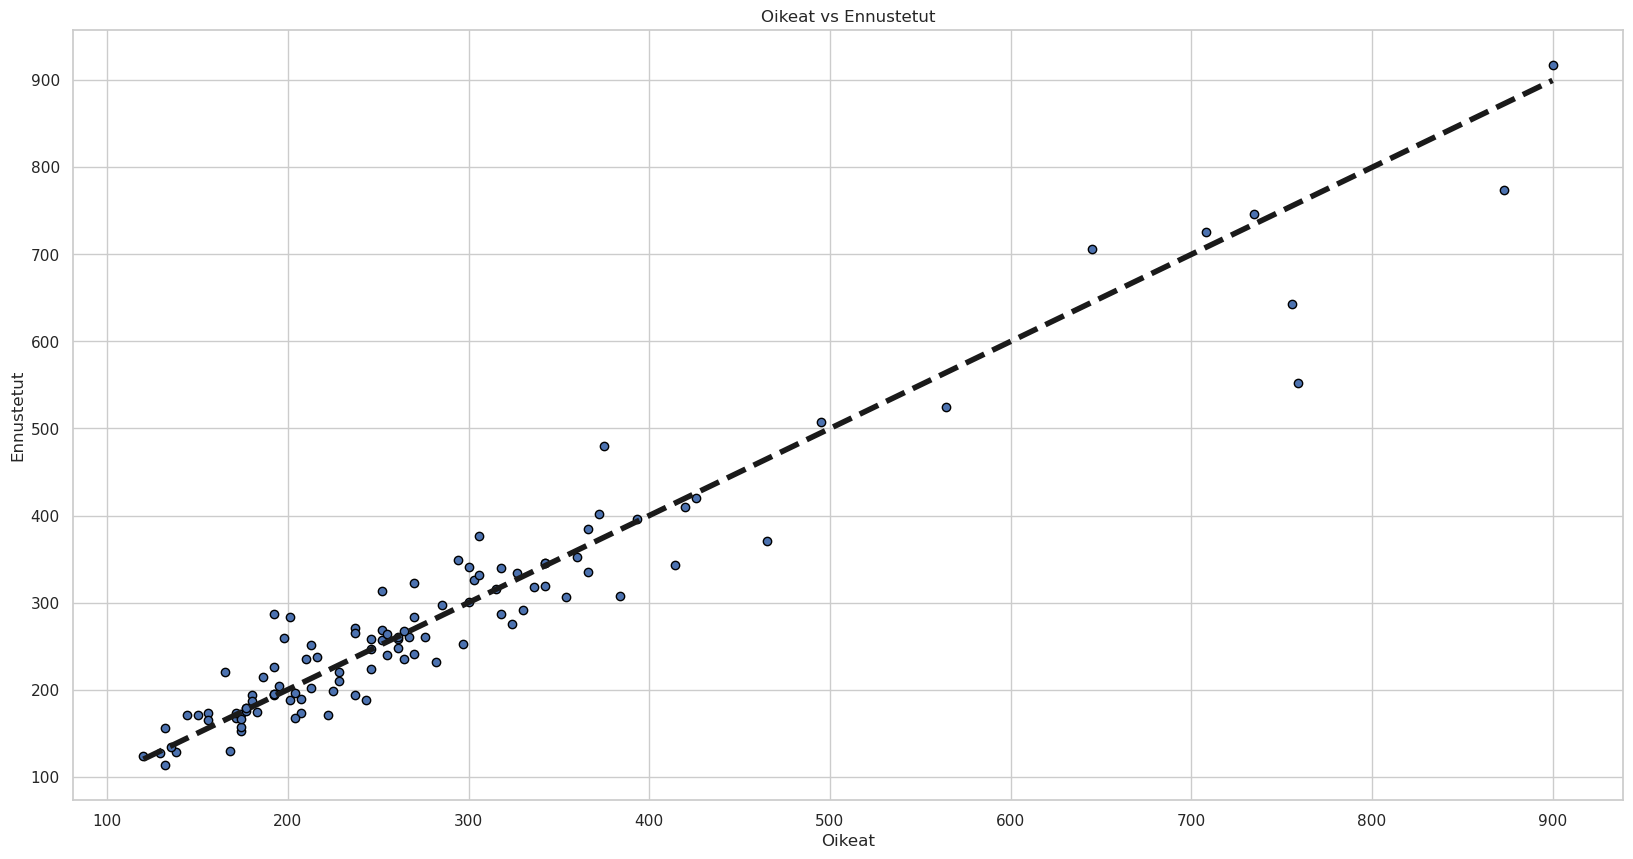

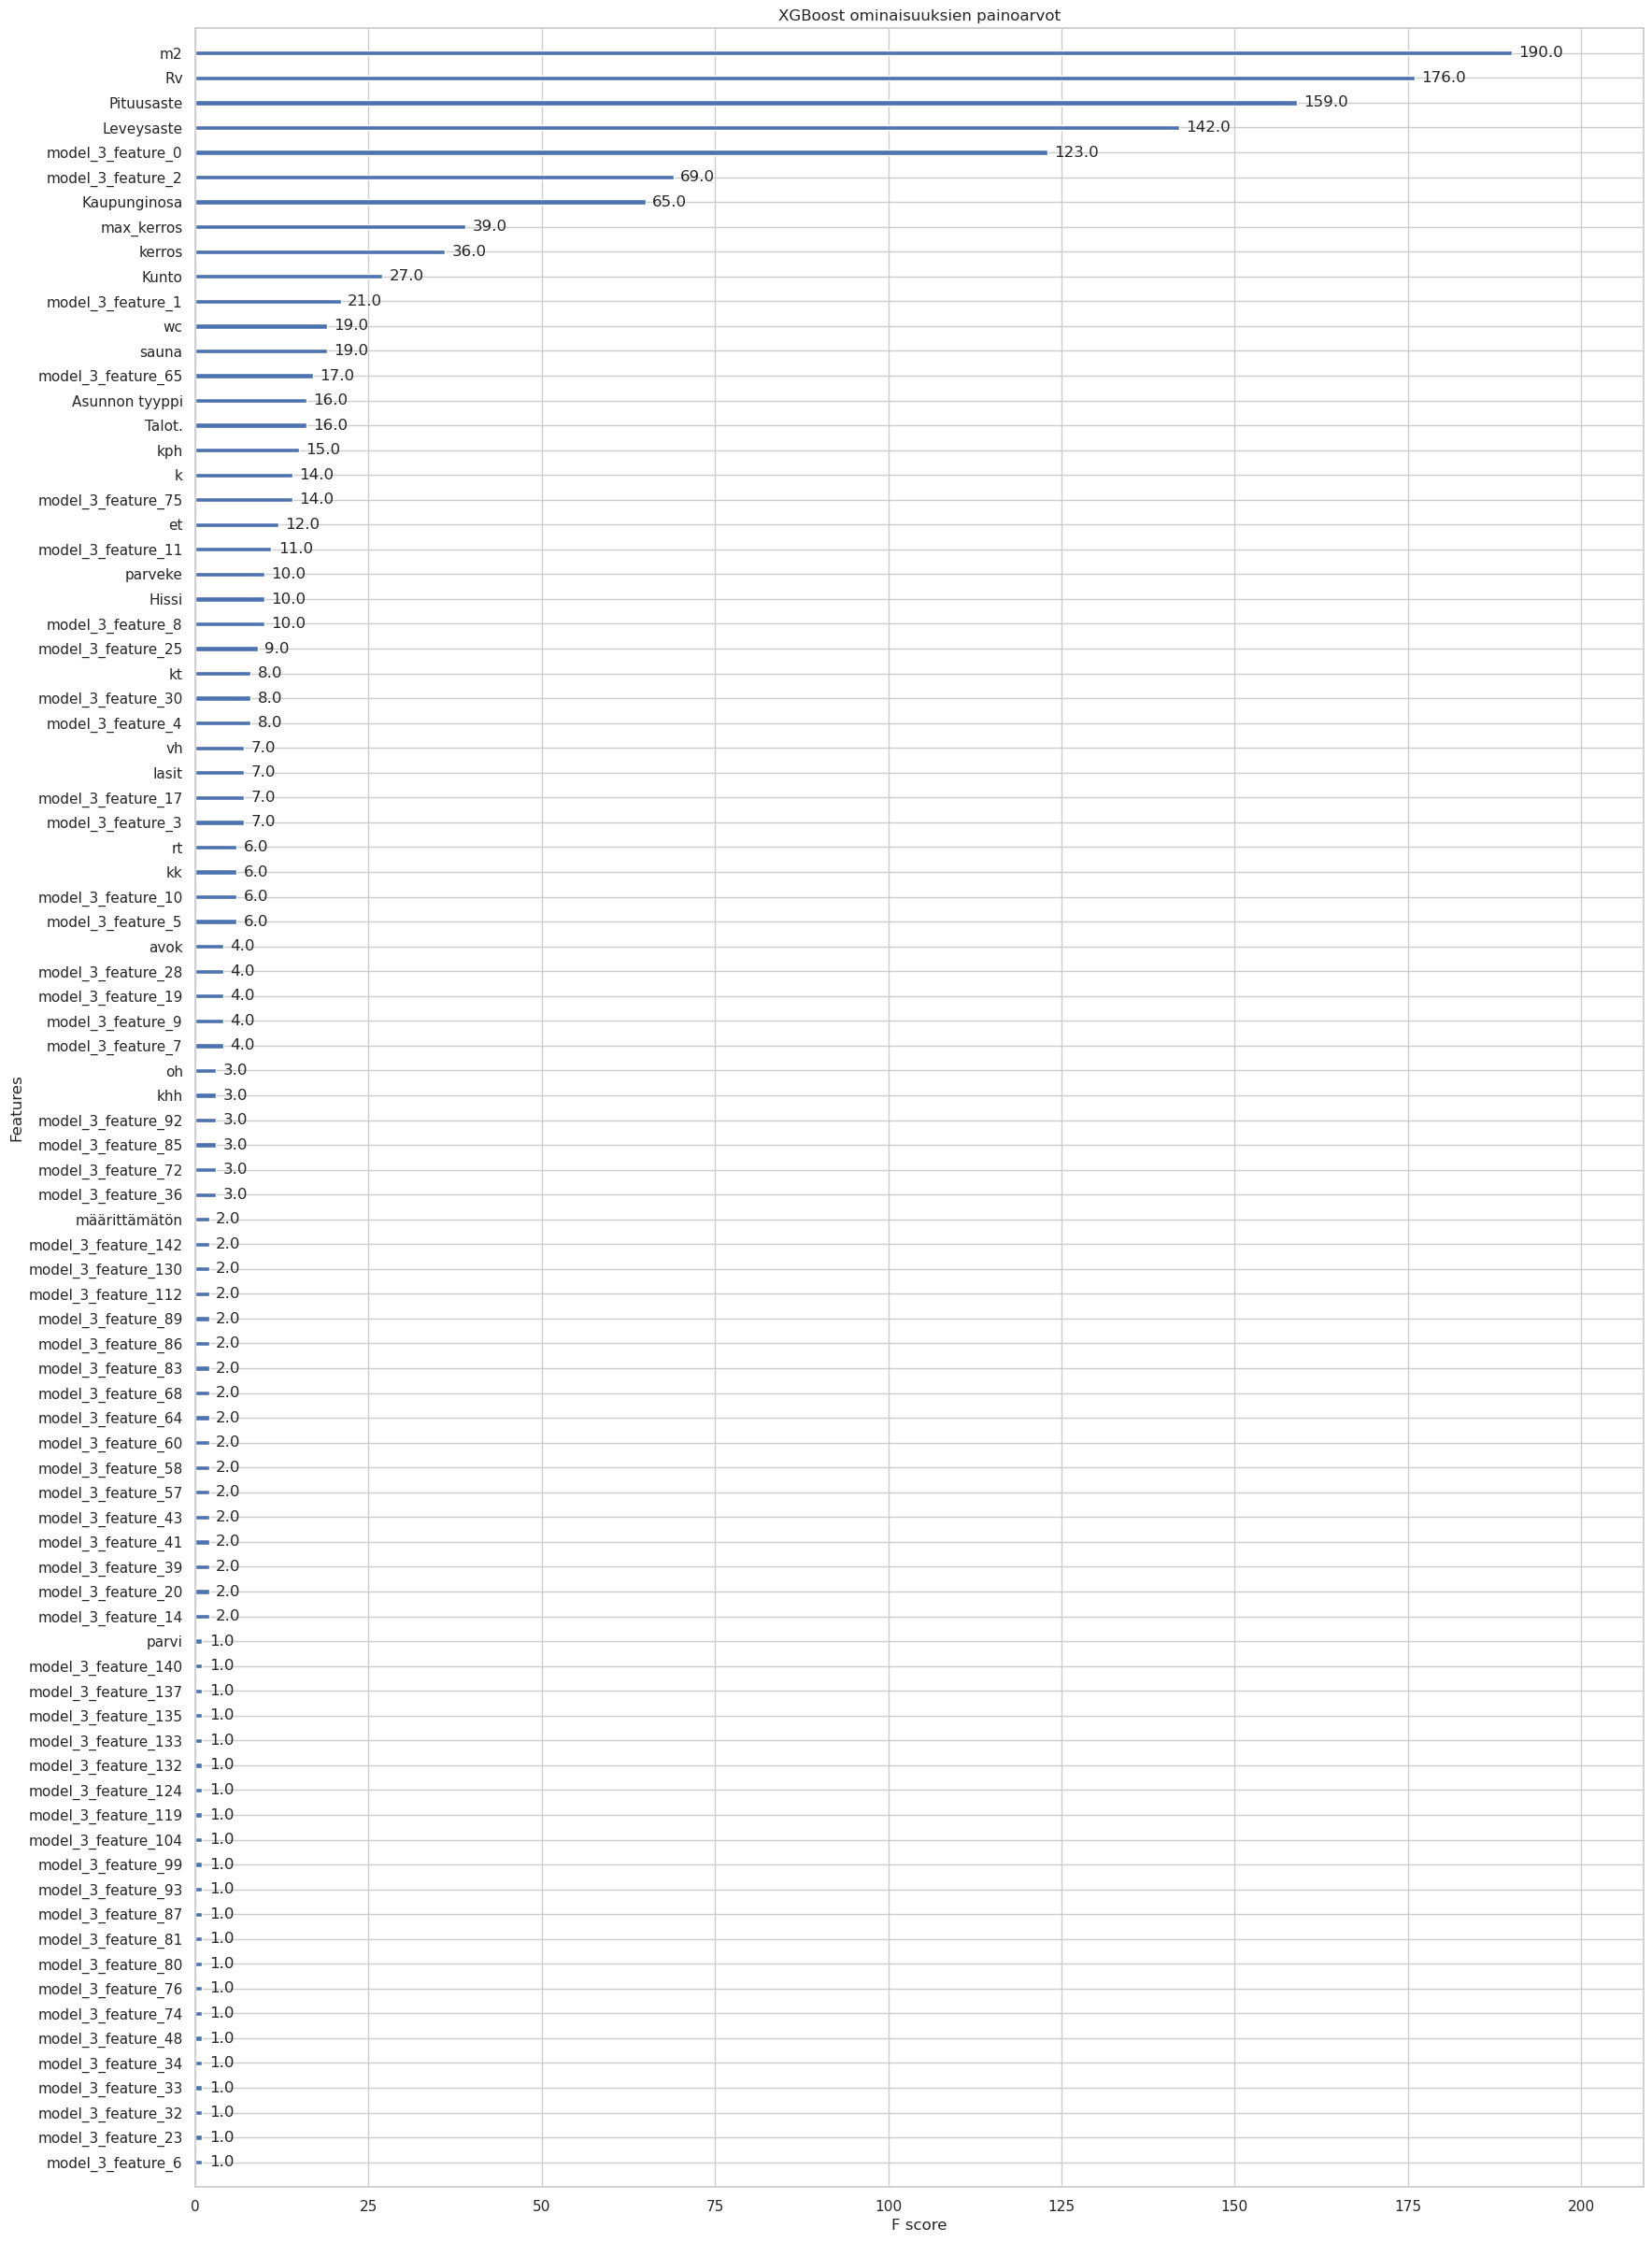

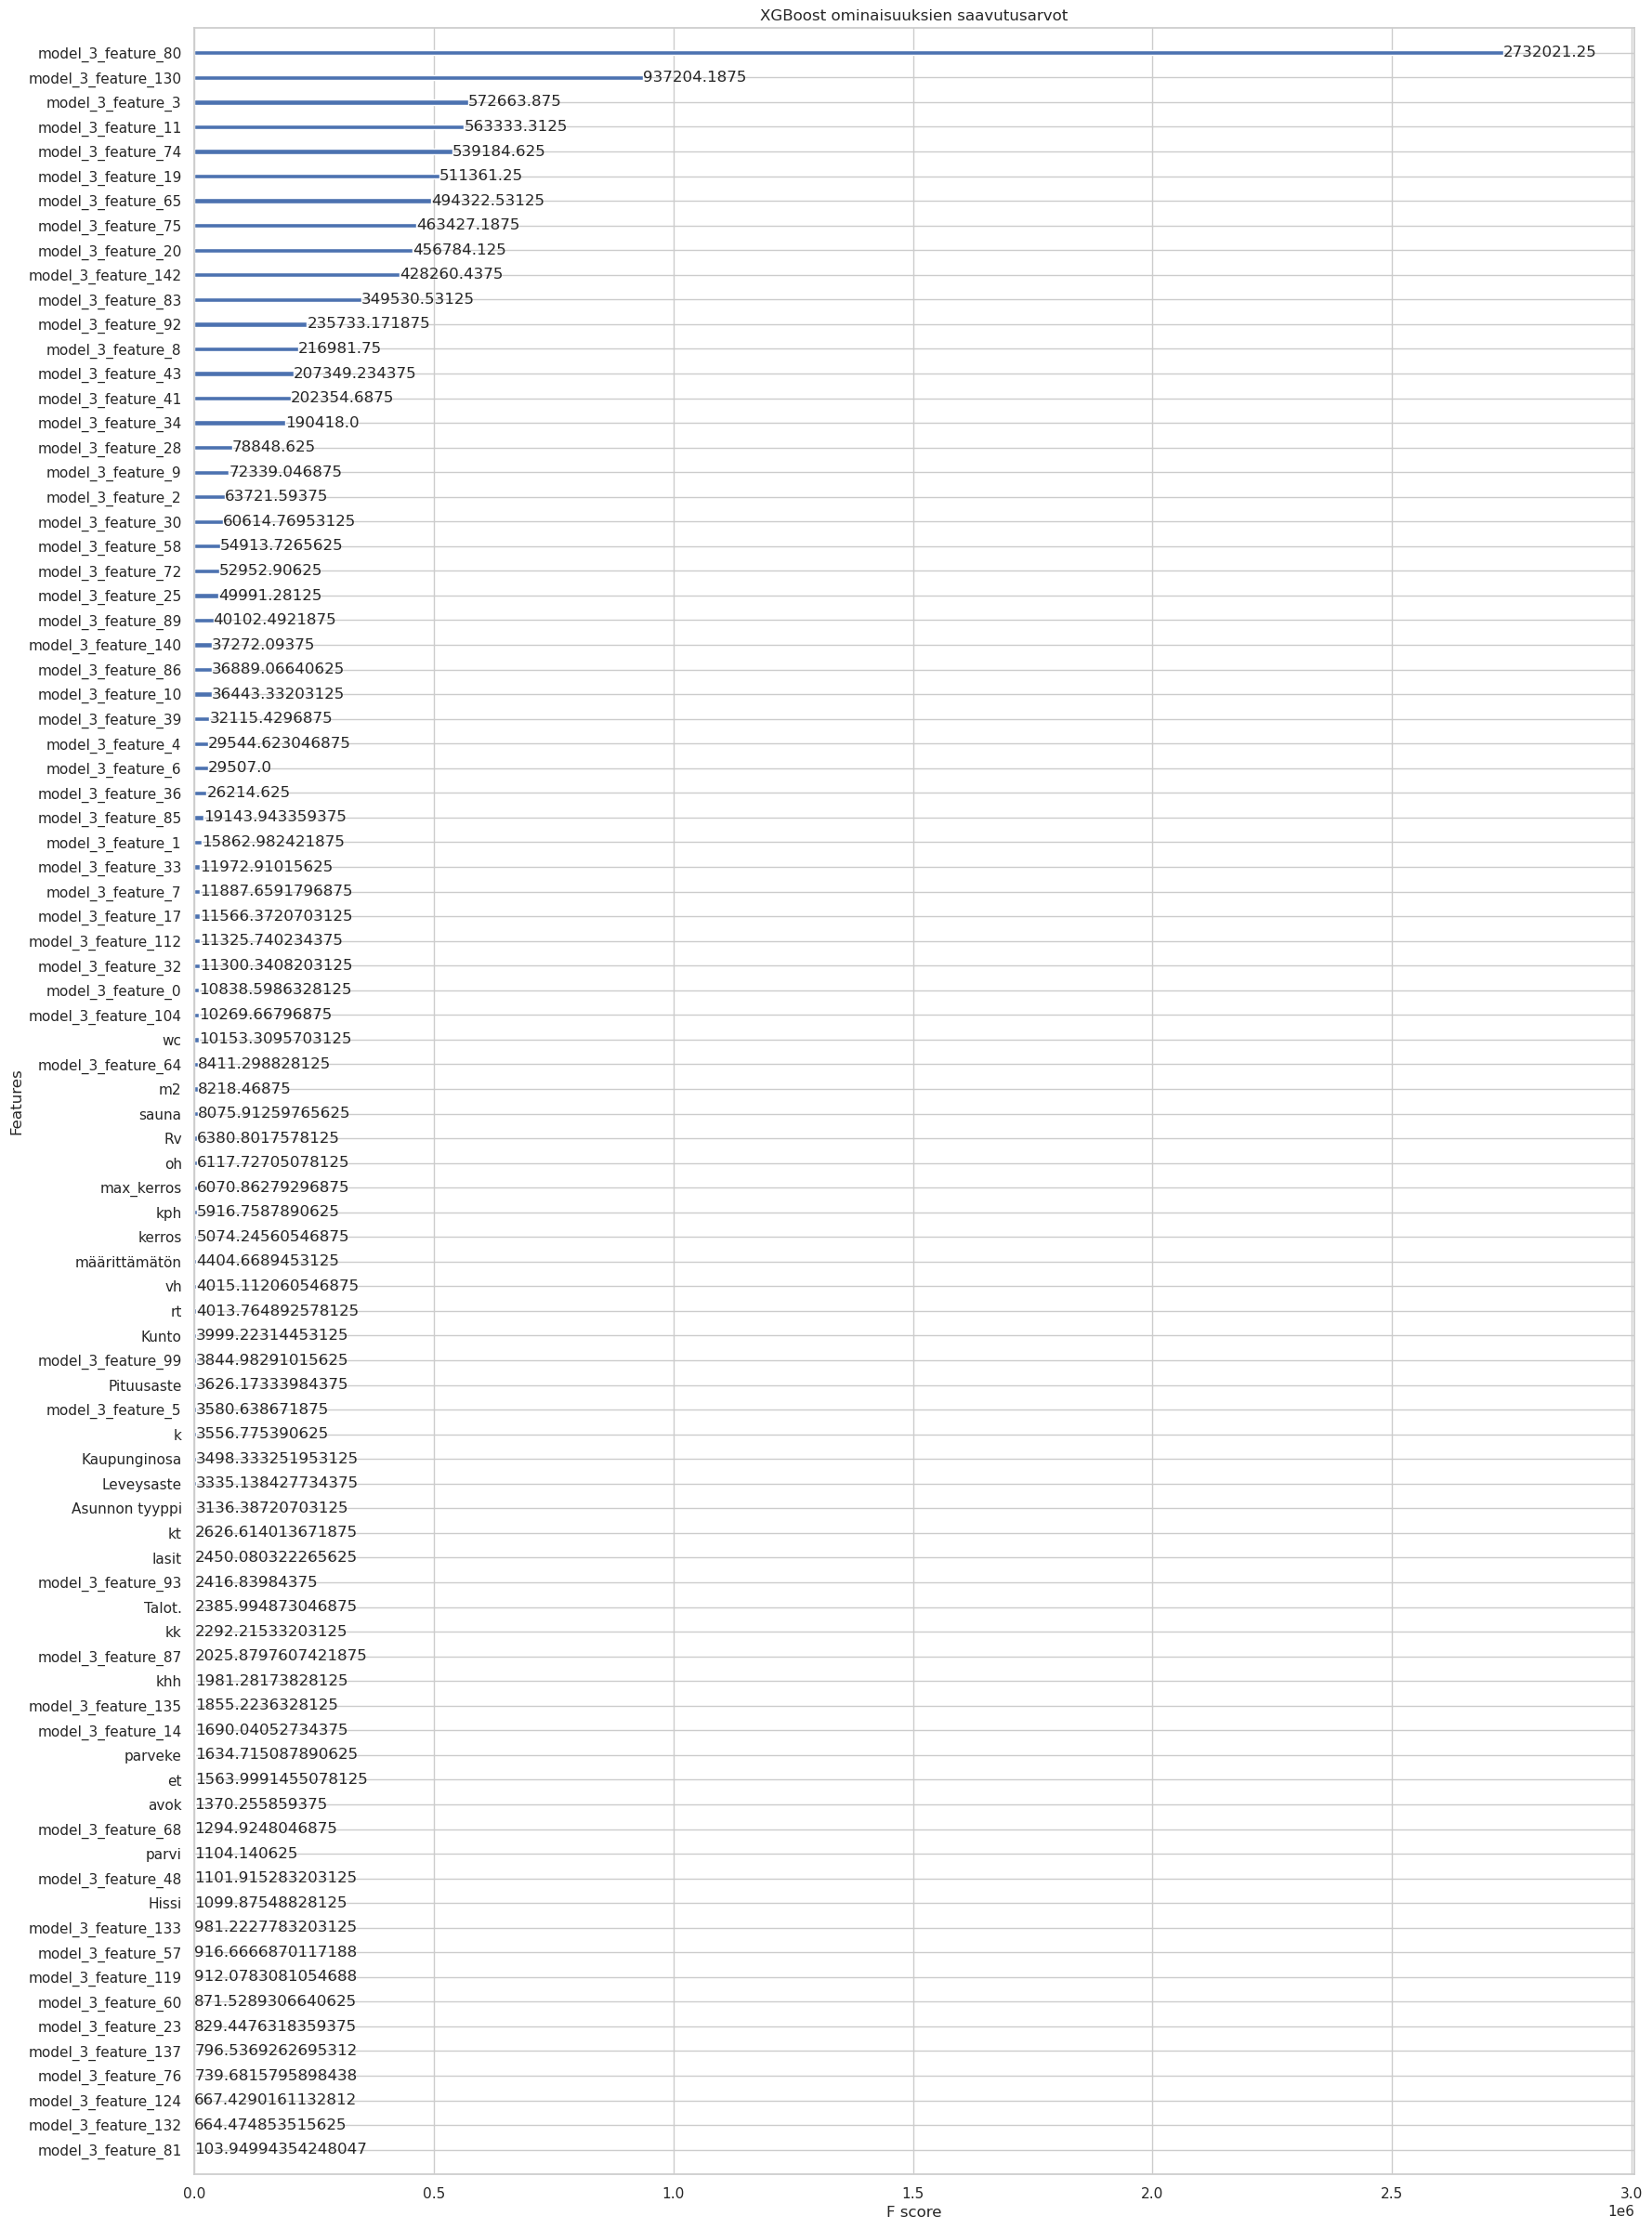

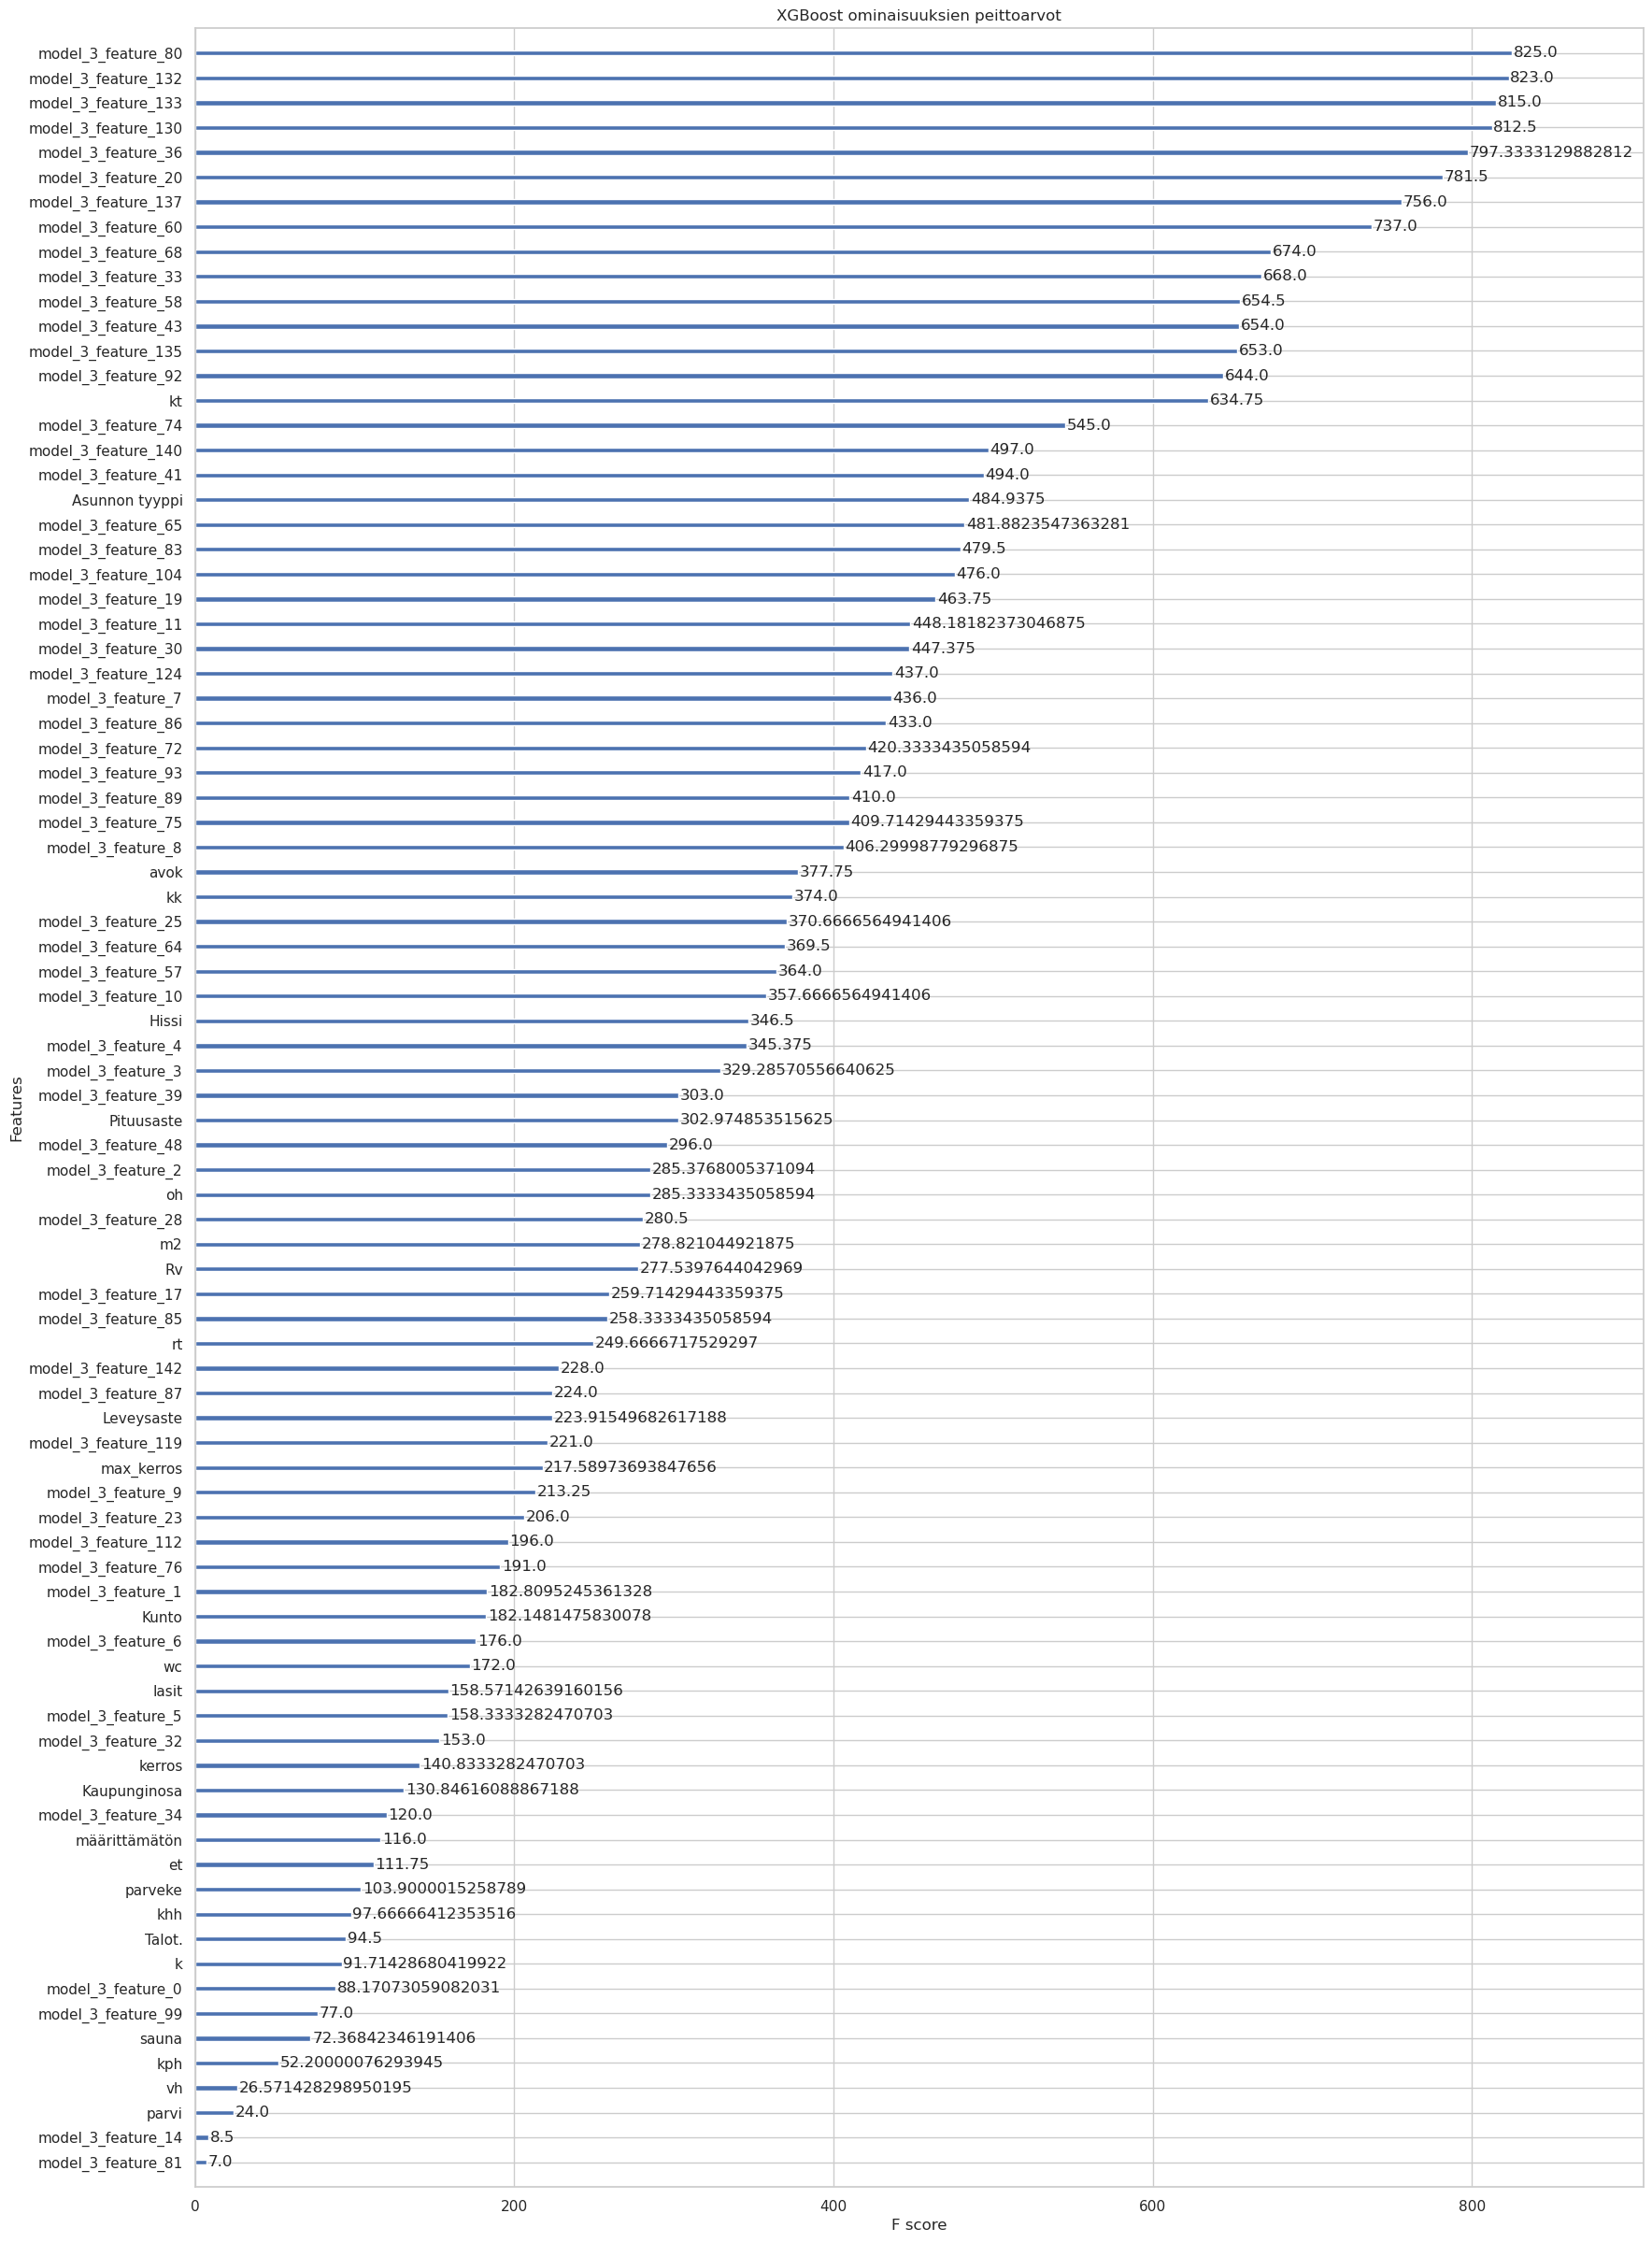

In [138]:
import warnings
from tensorflow.keras.models import Model
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from tensorflow.keras.models import Model
import glob
from tensorflow.keras.models import load_model
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings



# Montko quasirandom samplea ja montako tpe samplea ja kauanko tätä härveliä pyöritellään 
num_random = 50
num_tpe = 50
max_time_xgb = 3600 * 3


X_train_features_list = []
X_test_features_list = []
features_names_list = []

for idx, model in enumerate(best_models):
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_NN)
    X_test_features = feature_extractor.predict(X_test_NN)

    has_nan = np.isnan(X_train_features).any() or np.isnan(X_test_features).any()
    print(f'Model {idx} has nan values: {has_nan}')
    
    X_train_features_list.append(X_train_features)
    X_test_features_list.append(X_test_features)

    num_features = X_train_features.shape[1]
    model_feature_names = [f"model_{idx}_feature_{feature_idx}" for feature_idx in range(num_features)]
    features_names_list.append(model_feature_names)


original_feature_names = list(X_train.columns) 
combined_feature_names = original_feature_names + features_names_list

# Yhdistetään ominaisuusvektorit

def select_models(X_train_features_list, X_test_features_list, features_names_list, which_models):

    X_train_selected = []
    X_test_selected = []
    selected_names = []

    if all(not choosenode for choosenode in which_models):        
        X_train_selected = None
        X_test_selected = None
        selected_names = None

    else:
        for idx, choosenode in enumerate(which_models):
            if choosenode: 
                X_train_selected.append(X_train_features_list[idx])
                X_test_selected.append(X_test_features_list[idx])
                selected_names.extend(features_names_list[idx])                
            
        X_train_selected = np.concatenate(X_train_selected, axis=1)
        X_test_selected = np.concatenate(X_test_selected, axis=1)
        
        
    return X_train_selected, X_test_selected, selected_names
    

X_train_combined = np.concatenate(X_train_features_list, axis=1)
X_test_combined = np.concatenate(X_test_features_list, axis=1)

X_train_combined = np.concatenate([X_train_combined, X_train], axis=1)   
X_test_combined = np.concatenate([X_test_combined, X_test], axis=1)


def select_features(X_train_combined, X_test_combined, y_train, combined_feature_names, method, max_feature):
    
    if method == 'f_regression':
        method_function = f_regression
    elif method == 'mutual_info_regression':
        method_function = mutual_info_regression
    else:
        method_function = None

    if method_function is not None:
        selector = SelectKBest(method_function, k=max_feature)
        X_train_combined_selected = selector.fit_transform(X_train_combined, y_train)
        X_test_combined_selected = selector.transform(X_test_combined)
        selected_indices = selector.get_support(indices=True)
        selected_features_names = np.array(combined_feature_names)[selected_indices]
        selected_features_names = selected_features_names.tolist()
        
        return X_train_combined_selected, X_test_combined_selected, selected_features_names
    else:
        return X_train_combined, X_test_combined, combined_feature_names


def rmsle(y_true, y_pred):
    if np.any(y_pred <= 0):
        return 1e6
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))




def objective(trial):
    # Määritetään parametrit, jotka optimoidaan XGBoosrt
    param = {
        "booster": "dart",        
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 2, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 42, log = True),     
        'nthread' : -2
    }

    num_boost_round = trial.suggest_int('BRounds', 1, 142)  

    # Alla olevat liittyvät ominaisuuksien valitsemiseen. Valitettavasti nyt tämä härveli tukee vaan 5 foldia. Ei aikaa kiire on yöllä, että dynaamisesti tämä foldien mukaan. 
    selector = trial.suggest_categorical('S', choices = ['f_regression', 'mutual_info_regression', 'None'])
    select_0 = trial.suggest_categorical('S0', [True, False])
    select_1 = trial.suggest_categorical('S1', [True, False])
    select_2 = trial.suggest_categorical('S2', [True, False])
    select_3 = trial.suggest_categorical('S3', [True, False])
    select_4 = trial.suggest_categorical('S4', [True, False])

    X_train_combined_selected, X_test_combined_selected , selected_features_names = select_models(X_train_features_list, X_test_features_list, features_names_list, [select_0, select_1, select_2, select_3, select_4])

    if X_train_combined_selected is not None:
        combined_feature_names = selected_features_names + original_feature_names
        X_train_combined_selected = np.concatenate([X_train_combined_selected, X_train], axis=1)
        X_test_combined_selected = np.concatenate([X_test_combined_selected, X_test], axis=1)
    else:
        X_train_combined_selected = X_train
        X_test_combined_selected = X_test
        combined_feature_names = original_feature_names


    num_selected = trial.suggest_int('N_fea', 1, X_train_combined_selected.shape[1])
    X_train_combined_selected, _ , combined_feature_names = select_features(X_train_combined_selected, X_test_combined_selected, y_train, combined_feature_names, selector, num_selected)
    # print(f"Selected features: {combined_feature_names}")
    
    
    rmsle_scores = []
    dtrain_full = xgb.DMatrix(X_train_combined_selected, label=y_train, feature_names=combined_feature_names)

    skf =  StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    stratified_labels = df_strat
    for train_index, val_index in skf.split(X_train_NN, stratified_labels):
        
        dtrain = dtrain_full.slice(train_index)
        dval = dtrain_full.slice(val_index)

        evals_result = {}
        bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=[(dval, 'val')], evals_result=evals_result, verbose_eval=False, early_stopping_rounds=100)
        best_iteration = bst.best_iteration
        preds = bst.predict(dval, iteration_range=(0, best_iteration + 1))
        y_true = y_train[val_index]       
        loss = rmsle(y_true, preds)
        rmsle_scores.append(loss)

    average_rmsle = np.mean(rmsle_scores)
    return average_rmsle


study = optuna.create_study(direction='minimize',                                
                                study_name='XGBoost',
                                storage=f'sqlite:///tre_reg.db',
                                load_if_exists=True                                 
                                )

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.INFO)


time_xgb_start = time.time()

QMCsampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
TPEsampler = optuna.samplers.TPESampler(multivariate=True, n_startup_trials=0, warn_independent_sampling = False)

# Koulutuslooppi joka kouluttaa XGBoost kunnes aikaraja saavutettu
while time.time() - time_xgb_start < max_time_xgb:

    
    print(f'Random sampling {num_random} trials...')
    study.optimize(objective, n_trials=num_random)
    study.sampler = QMCsampler    
    print(f'TPE sampling {num_tpe} trials...')
    study.sampler = TPEsampler
    study.optimize(objective, n_trials=num_tpe)
    print(f'Best value so far: {study.best_value}')
    print(f'Best params so far: {study.best_params}')
    
    print(f'Time taken so far: {str(timedelta(seconds=(time.time() - time_xgb_start)))}')

print(f'Time taken for XGBoost optimization: {str(timedelta(seconds=(time.time() - time_xgb_start)))}')
print(f'Time taken for one trial: {str(timedelta(seconds=(time.time() - time_xgb_start) / (num_random + num_tpe)))}')

print(f"Best val: {study.best_trial.value}")
print(f'Best params: {study.best_params}')


# Nyt kun malli on valittu, niin voidaan kouluttaa se koko datalla ja testata sitä testidatalla
# Alla ensin otetaan Optunan valitsemat mallit jotka tuossa lopun listassa ovat "päälle/pois"
X_train_combined_selected, X_test_combined_selected , selected_features_names = select_models(X_train_features_list, X_test_features_list, features_names_list, [study.best_params['S0'], study.best_params['S1'], study.best_params['S2'], study.best_params['S3'], study.best_params['S4']])

if X_train_combined_selected is not None:
    combined_feature_names = selected_features_names + original_feature_names
    X_train_combined_selected = np.concatenate([X_train_combined_selected, X_train], axis=1)
    X_test_combined_selected = np.concatenate([X_test_combined_selected, X_test], axis=1)
else:
    X_train_combined_selected = X_train
    X_test_combined_selected = X_test
    combined_feature_names = original_feature_names

# Optuna myös valitsi kuinka monta parasta ominaisuutta napattiin tästä ominausuuskasasta mukaan.
X_train_combined_selected, X_test_combined_selected, selected_features_names = select_features(X_train_combined_selected, X_test_combined_selected, y_train, combined_feature_names, study.best_params['S'], study.best_params['N_fea'])

dtrain = xgb.DMatrix(X_train_combined_selected, label=y_train, feature_names=selected_features_names)
best_model = xgb.train(study.best_params, dtrain, num_boost_round=study.best_params['BRounds'])

# Testataan mallia koulutusdatalla jotta voidaan arvioda onko tässä koko hommassa mitään järkeä
pred_train = best_model.predict(dtrain)
mae_train = mean_absolute_error(y_train, pred_train)
mse_train = mean_squared_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
rmsle_train = rmsle(y_train, pred_train)
print(f"Train MAE: {mae_train}, Train MSE: {mse_train}, Train R2: {r2_train}, Train RMSLE: {rmsle_train}")

# Testataan mallia testidatalla  
dtest = xgb.DMatrix(X_test_combined_selected, label=y_test, feature_names=selected_features_names)
predictions = best_model.predict(dtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmsle_val = rmsle(y_test, predictions)
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}")

# Visualisoidaan ennustettuja arvoja verrattuna todellisiin arvoihin
plt.figure(figsize=(20, 10))
plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Oikeat')
plt.ylabel('Ennustetut')
plt.title('Oikeat vs Ennustetut')
plt.show()

# Katsellaan vielä mistä XGBoost oli kiinnostunut
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='weight', ax=ax)
ax.set_title('XGBoost ominaisuuksien painoarvot')
plt.show()

fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='gain', ax=ax)
ax.set_title('XGBoost ominaisuuksien saavutusarvot')
plt.show()

fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='cover', ax=ax)
ax.set_title('XGBoost ominaisuuksien peittoarvot')
plt.show()


